In [9]:
!pip install fbprophet
!pip install plotly
!pip install yfinance
!pip install prophet

import yfinance as yf
import pandas as pd
from datetime import datetime
from prophet import Prophet
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as po
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
init_notebook_mode(connected=True)
pio.renderers.default = 'colab'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet


#PART 1 : Web scraping and Data Extraction

In [10]:

# List of currency pairs with USD
currency_pairs = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'INR=X']

# Initialize an empty DataFrame to hold all data
all_currency_data = pd.DataFrame()

start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch data for each currency pair
for pair in currency_pairs:
    data = yf.download(pair, start=start_date, end=end_date, progress=False)
    if not data.empty:
        data['Currency_Pair'] = pair  # Add a column for the currency pair
        all_currency_data = pd.concat([all_currency_data, data], axis=0)

# Display the first few rows of the DataFrame
all_currency_data


,Open,High,Low,Close,Adj Close,Volume,Currency_Pair
Date,,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0,EURUSD=X
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0,EURUSD=X
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0,EURUSD=X
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0,EURUSD=X
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0,EURUSD=X
...,...,...,...,...,...,...,...
2023-12-06,83.315903,83.372299,83.288002,83.315903,83.315903,0,INR=X
2023-12-07,83.289597,83.391701,83.292801,83.289597,83.289597,0,INR=X
2023-12-08,83.354897,83.454002,81.026001,83.354897,83.354897,0,INR=X


#PART 2 : Data pre-processing and Analysis

##1.Reassigning currencypair values

In [11]:

# Define the function to fill NaN with the average of next and previous values
def fill_with_avg_of_neighbors(df):
    for col in df.columns:
        # Only apply to numeric columns
        if pd.api.types.is_numeric_dtype(df[col]):
            for i in df[col].index[df[col].isnull()]:
                # Get previous and next value
                prev_val = df[col].iloc[max(0, i-1)]
                next_val = df[col].iloc[min(len(df[col]) - 1, i+1)]

                # Calculate the average
                avg_val = (prev_val + next_val) / 2

                # Assign the average value to the null entry
                df.at[i, col] = avg_val
    return df

# Reset the index of the DataFrame
all_currency_data.reset_index(inplace=True)

# Fill NaN values with the average of the next and previous row's values
all_currency_data = fill_with_avg_of_neighbors(all_currency_data)

# Replace values in 'Currency_Pair' column
replacement_dict = {
    'EURUSD=X': 'EUR',
    'JPY=X': 'JPY',
    'GBPUSD=X': 'GBP',
    'CNY=X': 'CNY',
    'INR=X': 'INR'
}

all_currency_data['Currency_Pair'] = all_currency_data['Currency_Pair'].replace(replacement_dict)
all_currency_data


,Date,Open,High,Low,Close,Adj Close,Volume,Currency_Pair
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0,EUR
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0,EUR
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0,EUR
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0,EUR
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0,EUR
...,...,...,...,...,...,...,...,...
27416,2023-12-06,83.315903,83.372299,83.288002,83.315903,83.315903,0,INR
27417,2023-12-07,83.289597,83.391701,83.292801,83.289597,83.289597,0,INR
27418,2023-12-08,83.354897,83.454002,81.026001,83.354897,83.354897,0,INR
27419,2023-12-11,83.430099,83.441002,83.357300,83.430099,83.430099,0,INR


##2.Handling missing values

In [12]:

# Define the function to fill NaN with the average of next and previous values
def fill_with_avg_of_neighbors(df):
    for col in df.columns:
        # Only apply to numeric columns
        if pd.api.types.is_numeric_dtype(df[col]):
            for i in df[col].index[df[col].isnull()]:
                # Get previous and next value
                prev_val = df[col].iloc[max(0, i-1)]
                next_val = df[col].iloc[min(len(df[col]) - 1, i+1)]

                # Calculate the average
                avg_val = (prev_val + next_val) / 2

                # Assign the average value to the null entry
                df.at[i, col] = avg_val
    return df


# Fill NaN values with the average of the next and previous row's values
all_currency_data = fill_with_avg_of_neighbors(all_currency_data)
all_currency_data

,Date,Open,High,Low,Close,Adj Close,Volume,Currency_Pair
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0,EUR
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0,EUR
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0,EUR
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0,EUR
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0,EUR
...,...,...,...,...,...,...,...,...
27416,2023-12-06,83.315903,83.372299,83.288002,83.315903,83.315903,0,INR
27417,2023-12-07,83.289597,83.391701,83.292801,83.289597,83.289597,0,INR
27418,2023-12-08,83.354897,83.454002,81.026001,83.354897,83.354897,0,INR
27419,2023-12-11,83.430099,83.441002,83.357300,83.430099,83.430099,0,INR


##3.Formatting the numerical values and dropping volume column

The volume column is a completely null-valued column and hence will not be usefull in our model

In [13]:
# Colums to format and limit it to 3 digits after the decimal to preserve complexity
columns_to_format = ['Open', 'High', 'Low', 'Close']

# Apply rounding to three decimal places
all_currency_data[columns_to_format] = all_currency_data[columns_to_format].round(4)

#Dropping the volume column that is not useful
all_currency_data.drop(columns = 'Volume', axis =1, inplace = True)


##4.Calculating Return and Annulized volatility

In [14]:
currency_pairs = all_currency_data['Currency_Pair'].unique()


for pair in currency_pairs:
    # Using .loc to ensure changes are made to the original DataFrame
    subset_index = all_currency_data['Currency_Pair'] == pair
    all_currency_data.loc[subset_index, 'Return'] = all_currency_data.loc[subset_index, 'Adj Close'].pct_change()
    all_currency_data.loc[subset_index, 'Volatility'] = (
        all_currency_data.loc[subset_index, 'Return']
        .rolling(window=252)
        .std() * (252 ** 0.5)
    )
all_currency_data

,Date,Open,High,Low,Close,Adj Close,Currency_Pair,Return,Volatility
0,2003-12-01,1.2034,1.2040,1.1944,1.1965,1.196501,EUR,NaN,NaN
1,2003-12-02,1.1961,1.2109,1.1946,1.2089,1.208897,EUR,0.010360,NaN
2,2003-12-03,1.2090,1.2130,1.2077,1.2123,1.212298,EUR,0.002813,NaN
3,2003-12-04,1.2120,1.2144,1.2044,1.2081,1.208094,EUR,-0.003467,NaN
4,2003-12-05,1.2078,1.2191,1.2066,1.2187,1.218695,EUR,0.008775,NaN
...,...,...,...,...,...,...,...,...,...
27416,2023-12-06,83.3159,83.3723,83.2880,83.3159,83.315903,INR,-0.001213,0.046315
27417,2023-12-07,83.2896,83.3917,83.2928,83.2896,83.289597,INR,-0.000316,0.046283
27418,2023-12-08,83.3549,83.4540,81.0260,83.3549,83.354897,INR,0.000784,0.046284
27419,2023-12-11,83.4301,83.4410,83.3573,83.4301,83.430099,INR,0.000902,0.046202


##5.Vizualization of closing value over time

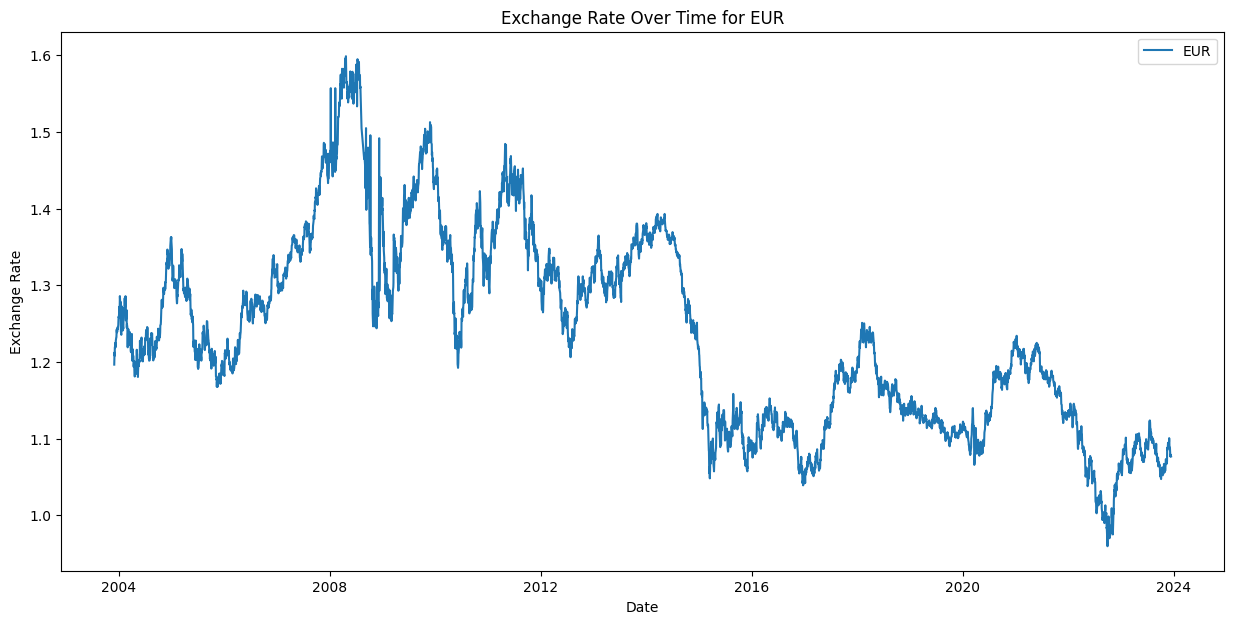

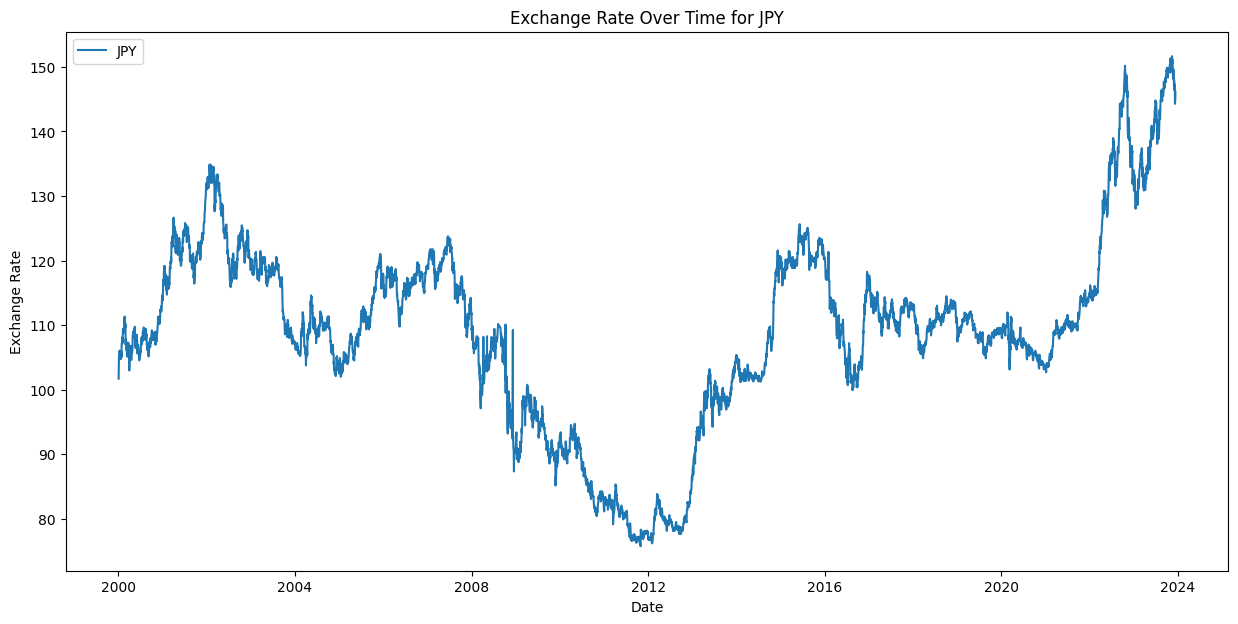

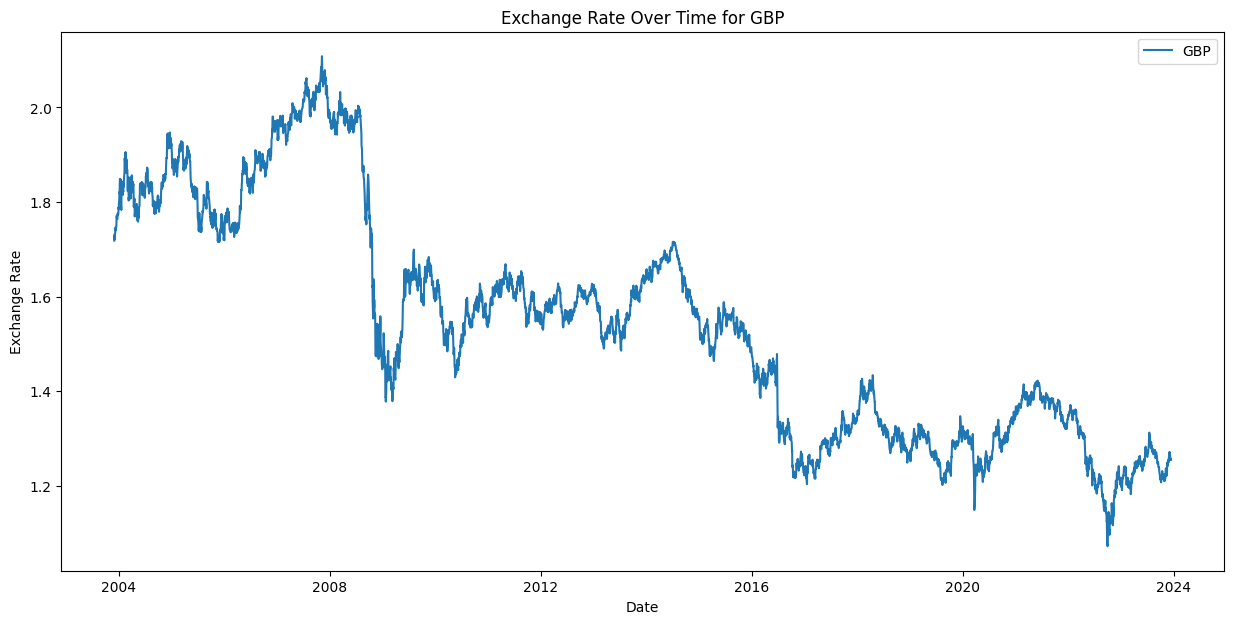

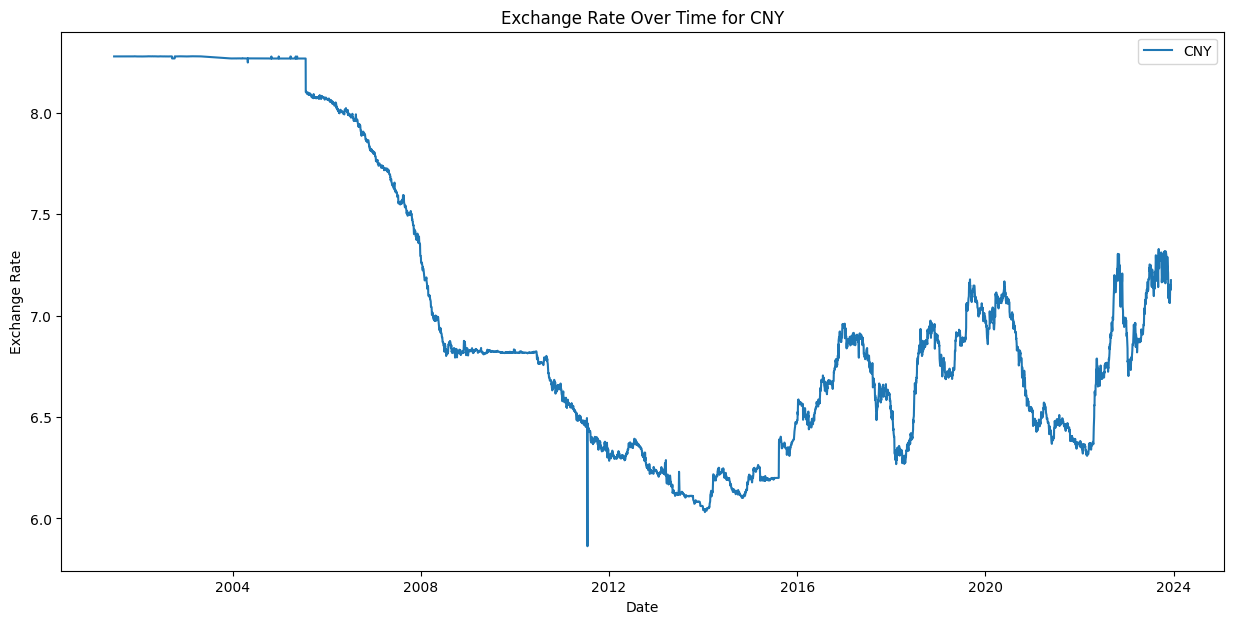

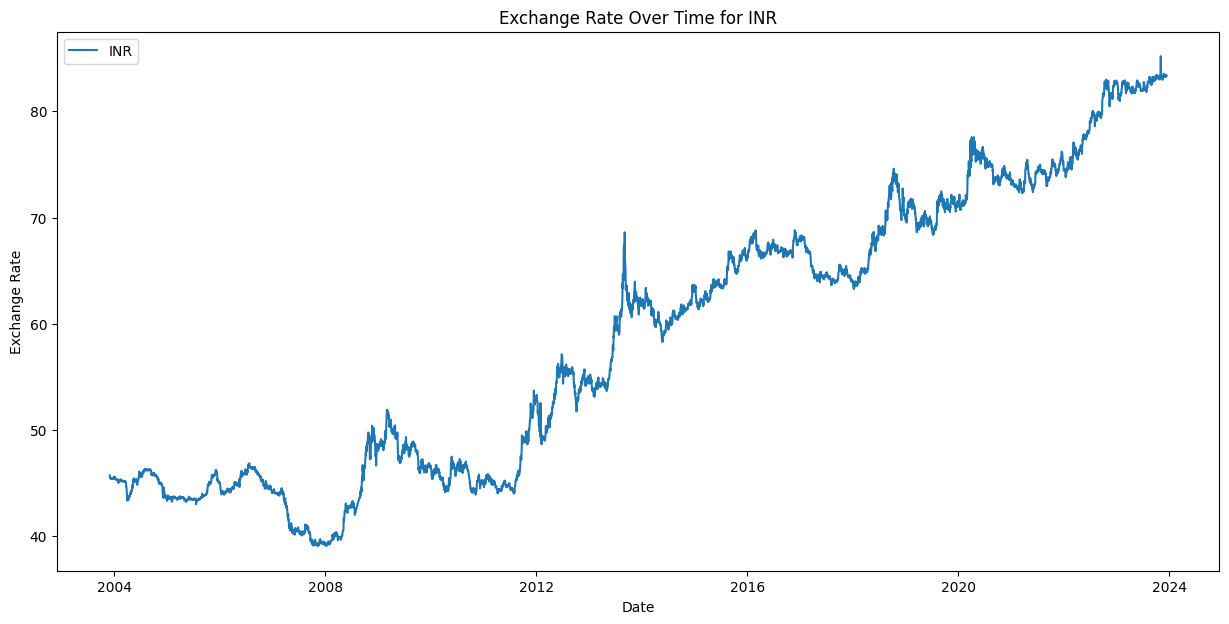

In [15]:
currency_pairs = ['EUR', 'JPY', 'GBP', 'CNY', 'INR']

# Assuming all_currency_data is your DataFrame and currency_pairs is a list of currency pairs
for pair in currency_pairs:
    subset = all_currency_data[all_currency_data['Currency_Pair'] == pair]

    # Create a new figure for each currency pair
    plt.figure(figsize=(15, 7))
    plt.plot(subset['Date'], subset['Adj Close'], label=pair)

    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.title(f'Exchange Rate Over Time for {pair}')
    plt.legend()
    plt.show()



##6.Density plots of closing values

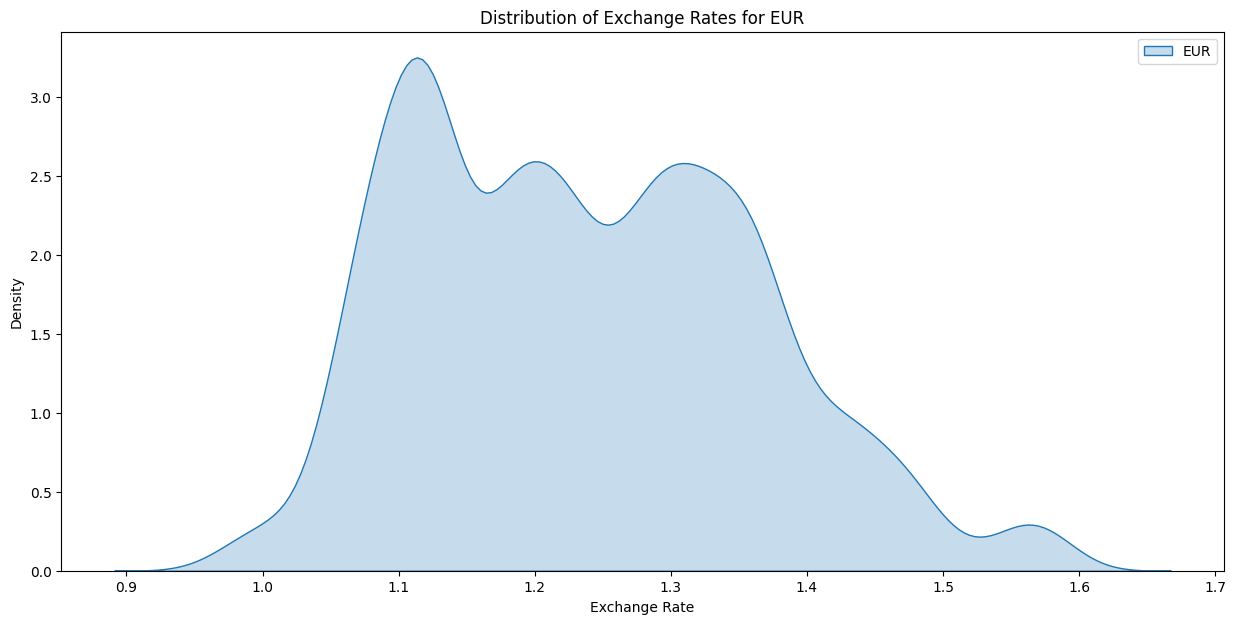

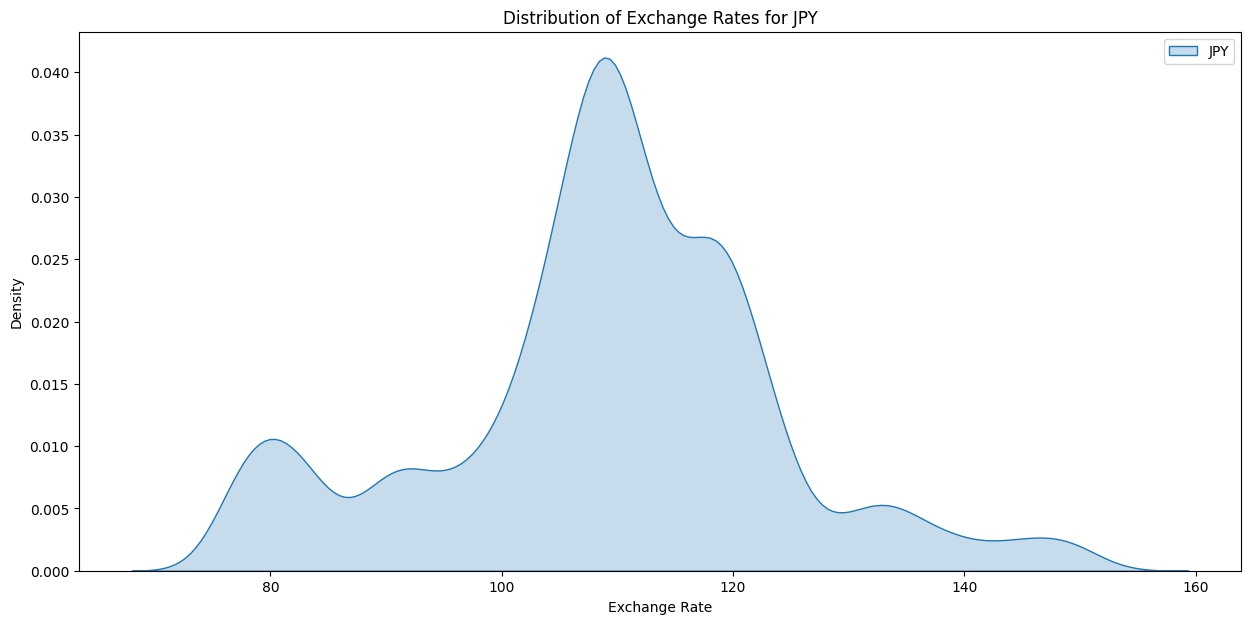

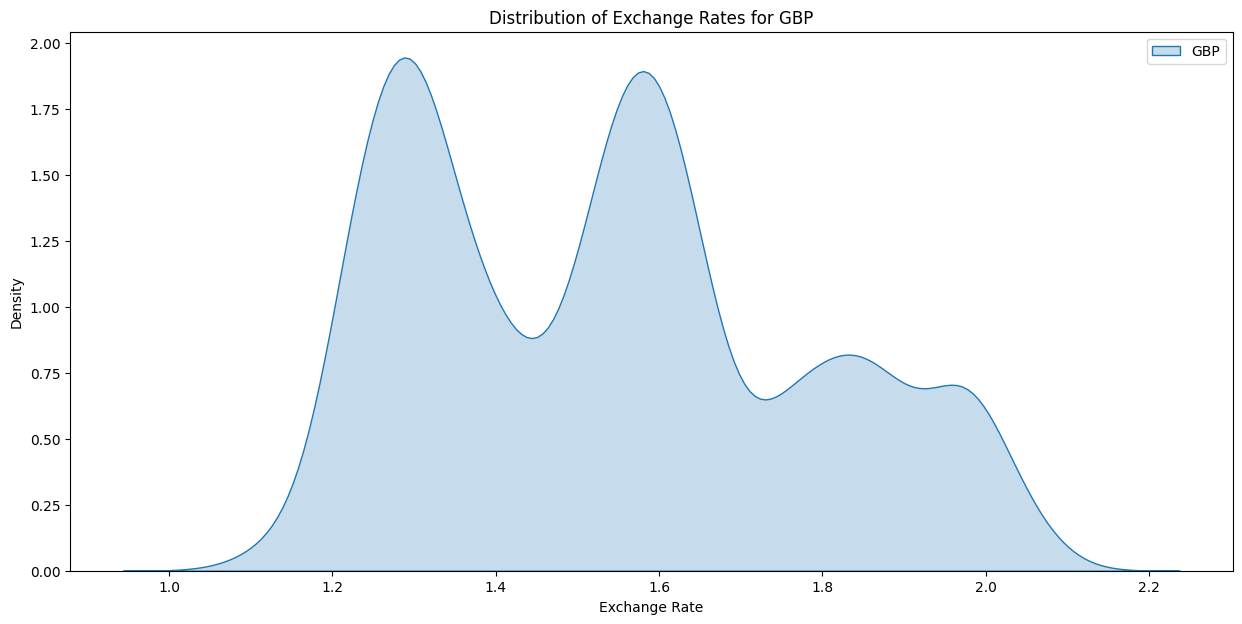

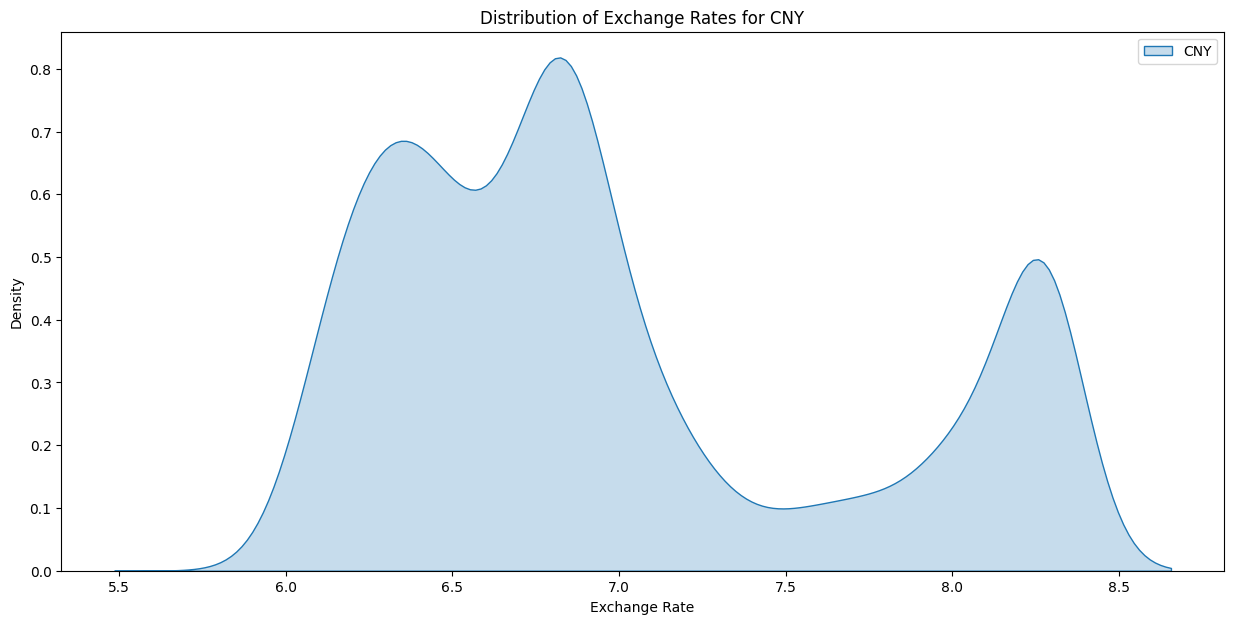

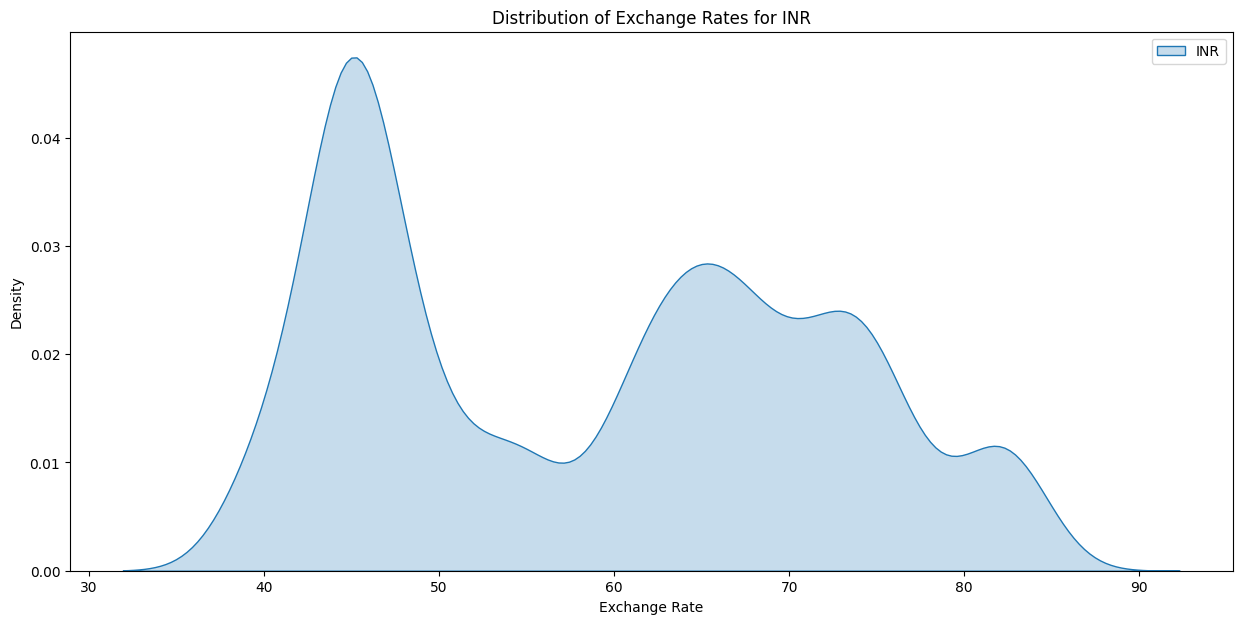

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_currency_data is your DataFrame and currency_pairs is a list of currency pairs
for pair in currency_pairs:
    subset = all_currency_data[all_currency_data['Currency_Pair'] == pair]

    # Create a new figure for each currency pair
    plt.figure(figsize=(15, 7))
    sns.kdeplot(subset['Adj Close'].dropna(), label=pair, fill=True)

    plt.xlabel('Exchange Rate')
    plt.ylabel('Density')
    plt.title(f'Distribution of Exchange Rates for {pair}')
    plt.legend()
    plt.show()

##7.Volatility Analysis

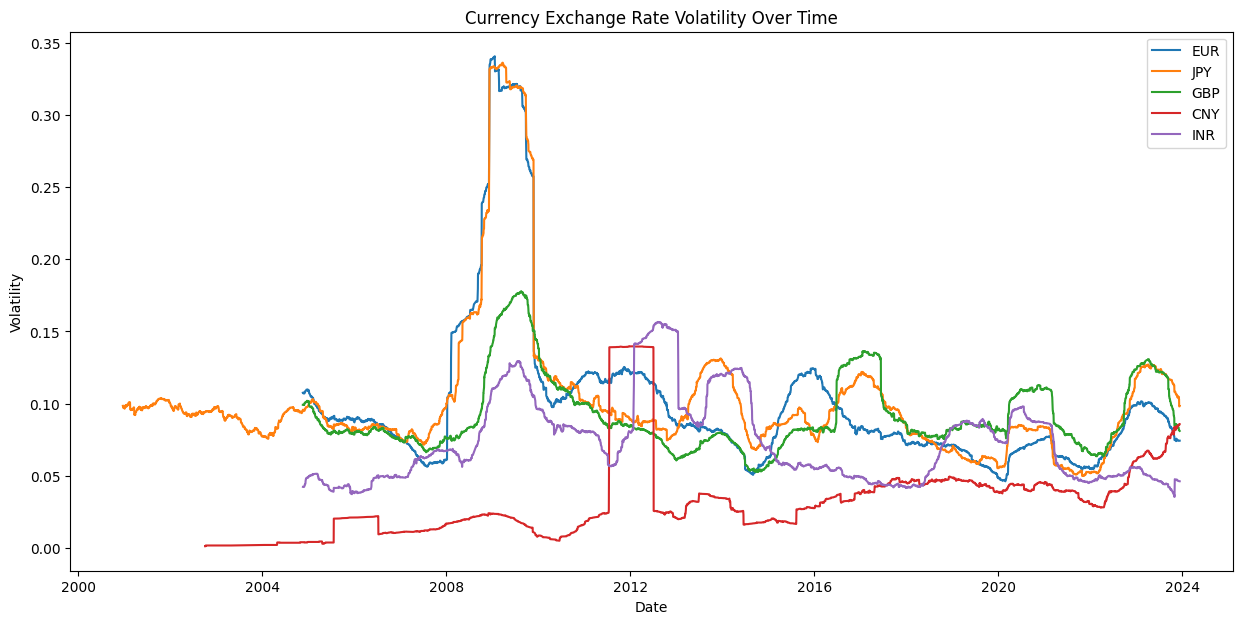

In [17]:
# Volatility Analysis
plt.figure(figsize=(15, 7))
for pair in currency_pairs:
    # Using .loc to ensure changes are made to the original DataFrame
    subset_index = all_currency_data['Currency_Pair'] == pair
    all_currency_data.loc[subset_index, 'Return'] = all_currency_data.loc[subset_index, 'Adj Close'].pct_change()
    all_currency_data.loc[subset_index, 'Volatility'] = all_currency_data.loc[subset_index, 'Return'].rolling(window=252).std() * (252 ** 0.5)

    plt.plot(all_currency_data.loc[subset_index, 'Date'], all_currency_data.loc[subset_index, 'Volatility'], label=pair)

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Currency Exchange Rate Volatility Over Time')
plt.legend()
plt.show()

##8.Correlation between different currencies

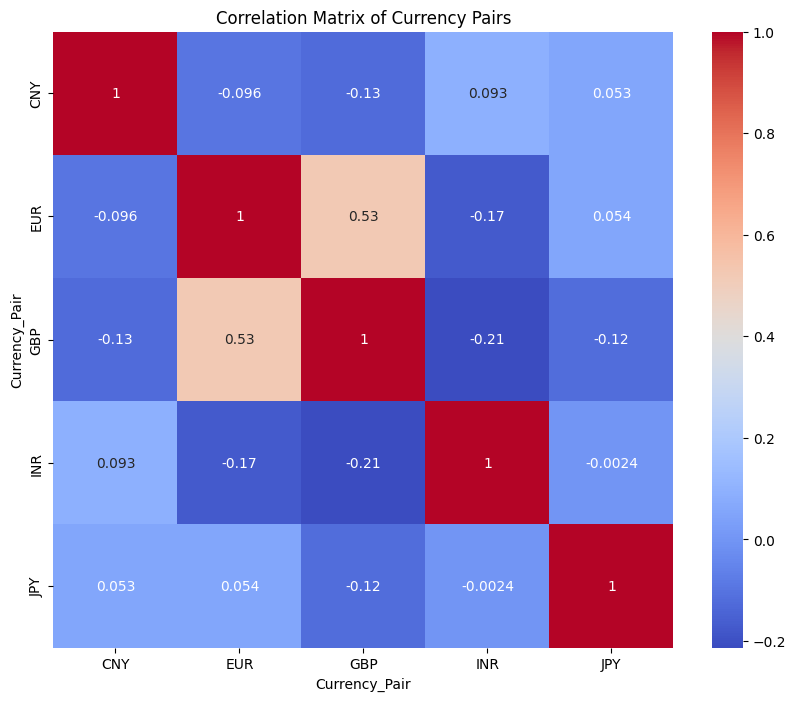

Missing values per column:
Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Currency_Pair    0
Return           0
Volatility       0
dtype: int64


In [18]:
# Correlation Analysis
returns = all_currency_data.pivot_table(values='Adj Close', index='Date', columns='Currency_Pair').pct_change()
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Currency Pairs')
plt.show()


# Reset the index of the DataFrame
all_currency_data.reset_index(inplace=True)
all_currency_data.drop(columns = 'index', axis =1, inplace = True)
# Fill NaN values with the average of the next and previous row's values
all_currency_data = fill_with_avg_of_neighbors(all_currency_data)


all_currency_data.fillna(0, inplace=True)
missing_values = all_currency_data.isna().sum()
if not missing_values.empty:
    print("Missing values per column:")
    print(missing_values)

##9.Checking for missing values

In [19]:
# Reset the index of the DataFrame
all_currency_data.reset_index(inplace=True)
all_currency_data.drop(columns = 'index', axis =1, inplace = True)
# Fill NaN values with the average of the next and previous row's values
all_currency_data = fill_with_avg_of_neighbors(all_currency_data)


all_currency_data.fillna(0, inplace=True)
missing_values = all_currency_data.isna().sum()
if not missing_values.empty:
    print("Missing values per column:")
    print(missing_values)

all_currency_data

Missing values per column:
Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Currency_Pair    0
Return           0
Volatility       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Currency_Pair,Return,Volatility
0,2003-12-01,1.2034,1.2040,1.1944,1.1965,1.196501,EUR,0.000000,0.000000
1,2003-12-02,1.1961,1.2109,1.1946,1.2089,1.208897,EUR,0.010360,0.000000
2,2003-12-03,1.2090,1.2130,1.2077,1.2123,1.212298,EUR,0.002813,0.000000
3,2003-12-04,1.2120,1.2144,1.2044,1.2081,1.208094,EUR,-0.003467,0.000000
4,2003-12-05,1.2078,1.2191,1.2066,1.2187,1.218695,EUR,0.008775,0.000000
...,...,...,...,...,...,...,...,...,...
27416,2023-12-06,83.3159,83.3723,83.2880,83.3159,83.315903,INR,-0.001213,0.046315
27417,2023-12-07,83.2896,83.3917,83.2928,83.2896,83.289597,INR,-0.000316,0.046283
27418,2023-12-08,83.3549,83.4540,81.0260,83.3549,83.354897,INR,0.000784,0.046284
27419,2023-12-11,83.4301,83.4410,83.3573,83.4301,83.430099,INR,0.000902,0.046202


##10.Removing Outliers

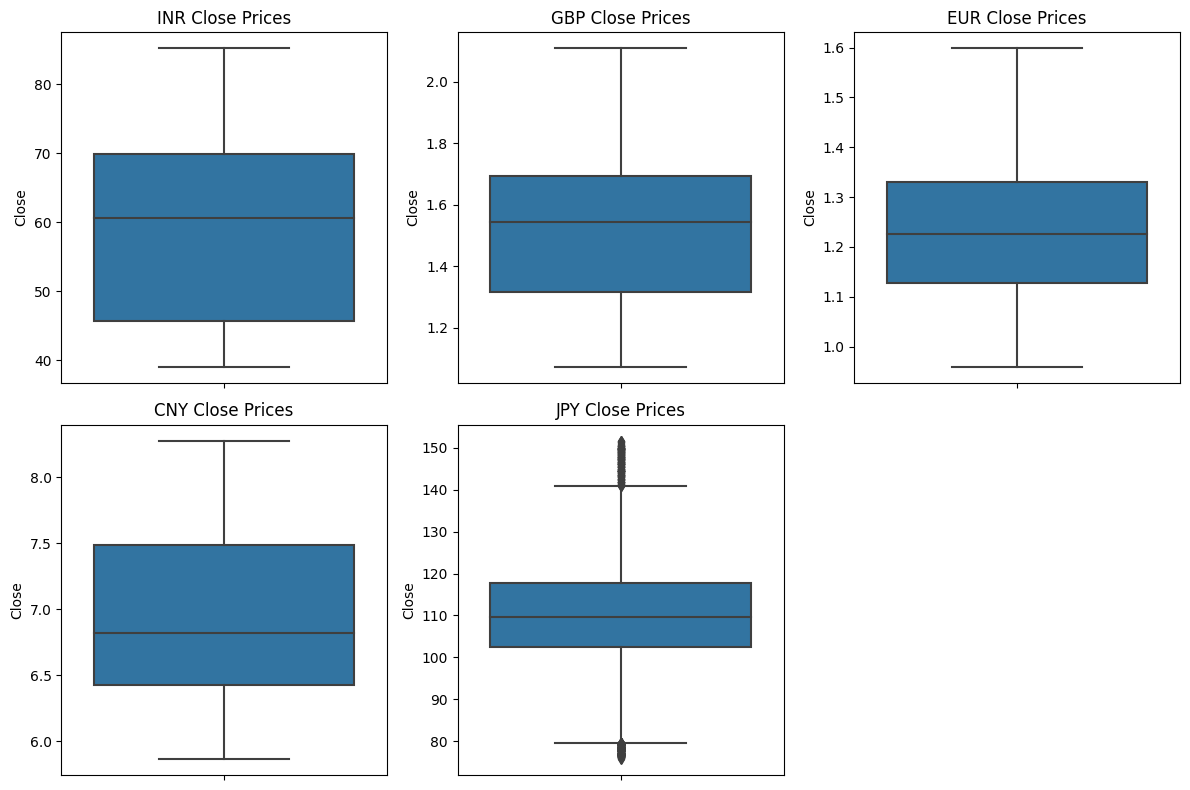

In [48]:
# check for outliers
def remove_outliers(data):

  Q1 = data['Close'].quantile(0.25)
  Q3 = data['Close'].quantile(0.75)
  IQR = Q3 - Q1

  # Define bounds for what you consider to be an outlier
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out the outliers
  data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]

  return data


df = pd.DataFrame()
all_currency_data_cleaned = pd.DataFrame()

for curr in ['INR','GBP','EUR','CNY']:
  df = remove_outliers(all_currency_data[all_currency_data['Currency_Pair']==curr])

  all_currency_data_cleaned = pd.concat([all_currency_data_cleaned,df], axis = 0)

data = all_currency_data[all_currency_data['Currency_Pair'] == 'JPY']
'''
#For Japan
data = all_currency_data
currency_pair = 'JPY'
data = data[data['Currency_Pair'] == currency_pair]


# check for outliers
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what you consider to be an outlier
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1.15 * IQR

# Filter out the outliers
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]
'''
#Concat the data
all_currency_data_cleaned = pd.concat([all_currency_data_cleaned,data], axis = 0)

# Generating individual box plots for each currency pair
currency_pairs = all_currency_data_cleaned['Currency_Pair'].unique()

plt.figure(figsize=(12, 8))

for i, currency_pair in enumerate(currency_pairs, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y='Close', data=all_currency_data_cleaned[all_currency_data_cleaned['Currency_Pair'] == currency_pair])
    plt.title(f'{currency_pair} Close Prices')
    plt.tight_layout()

plt.show()



##11.Decomposition

<Figure size 1500x1200 with 0 Axes>

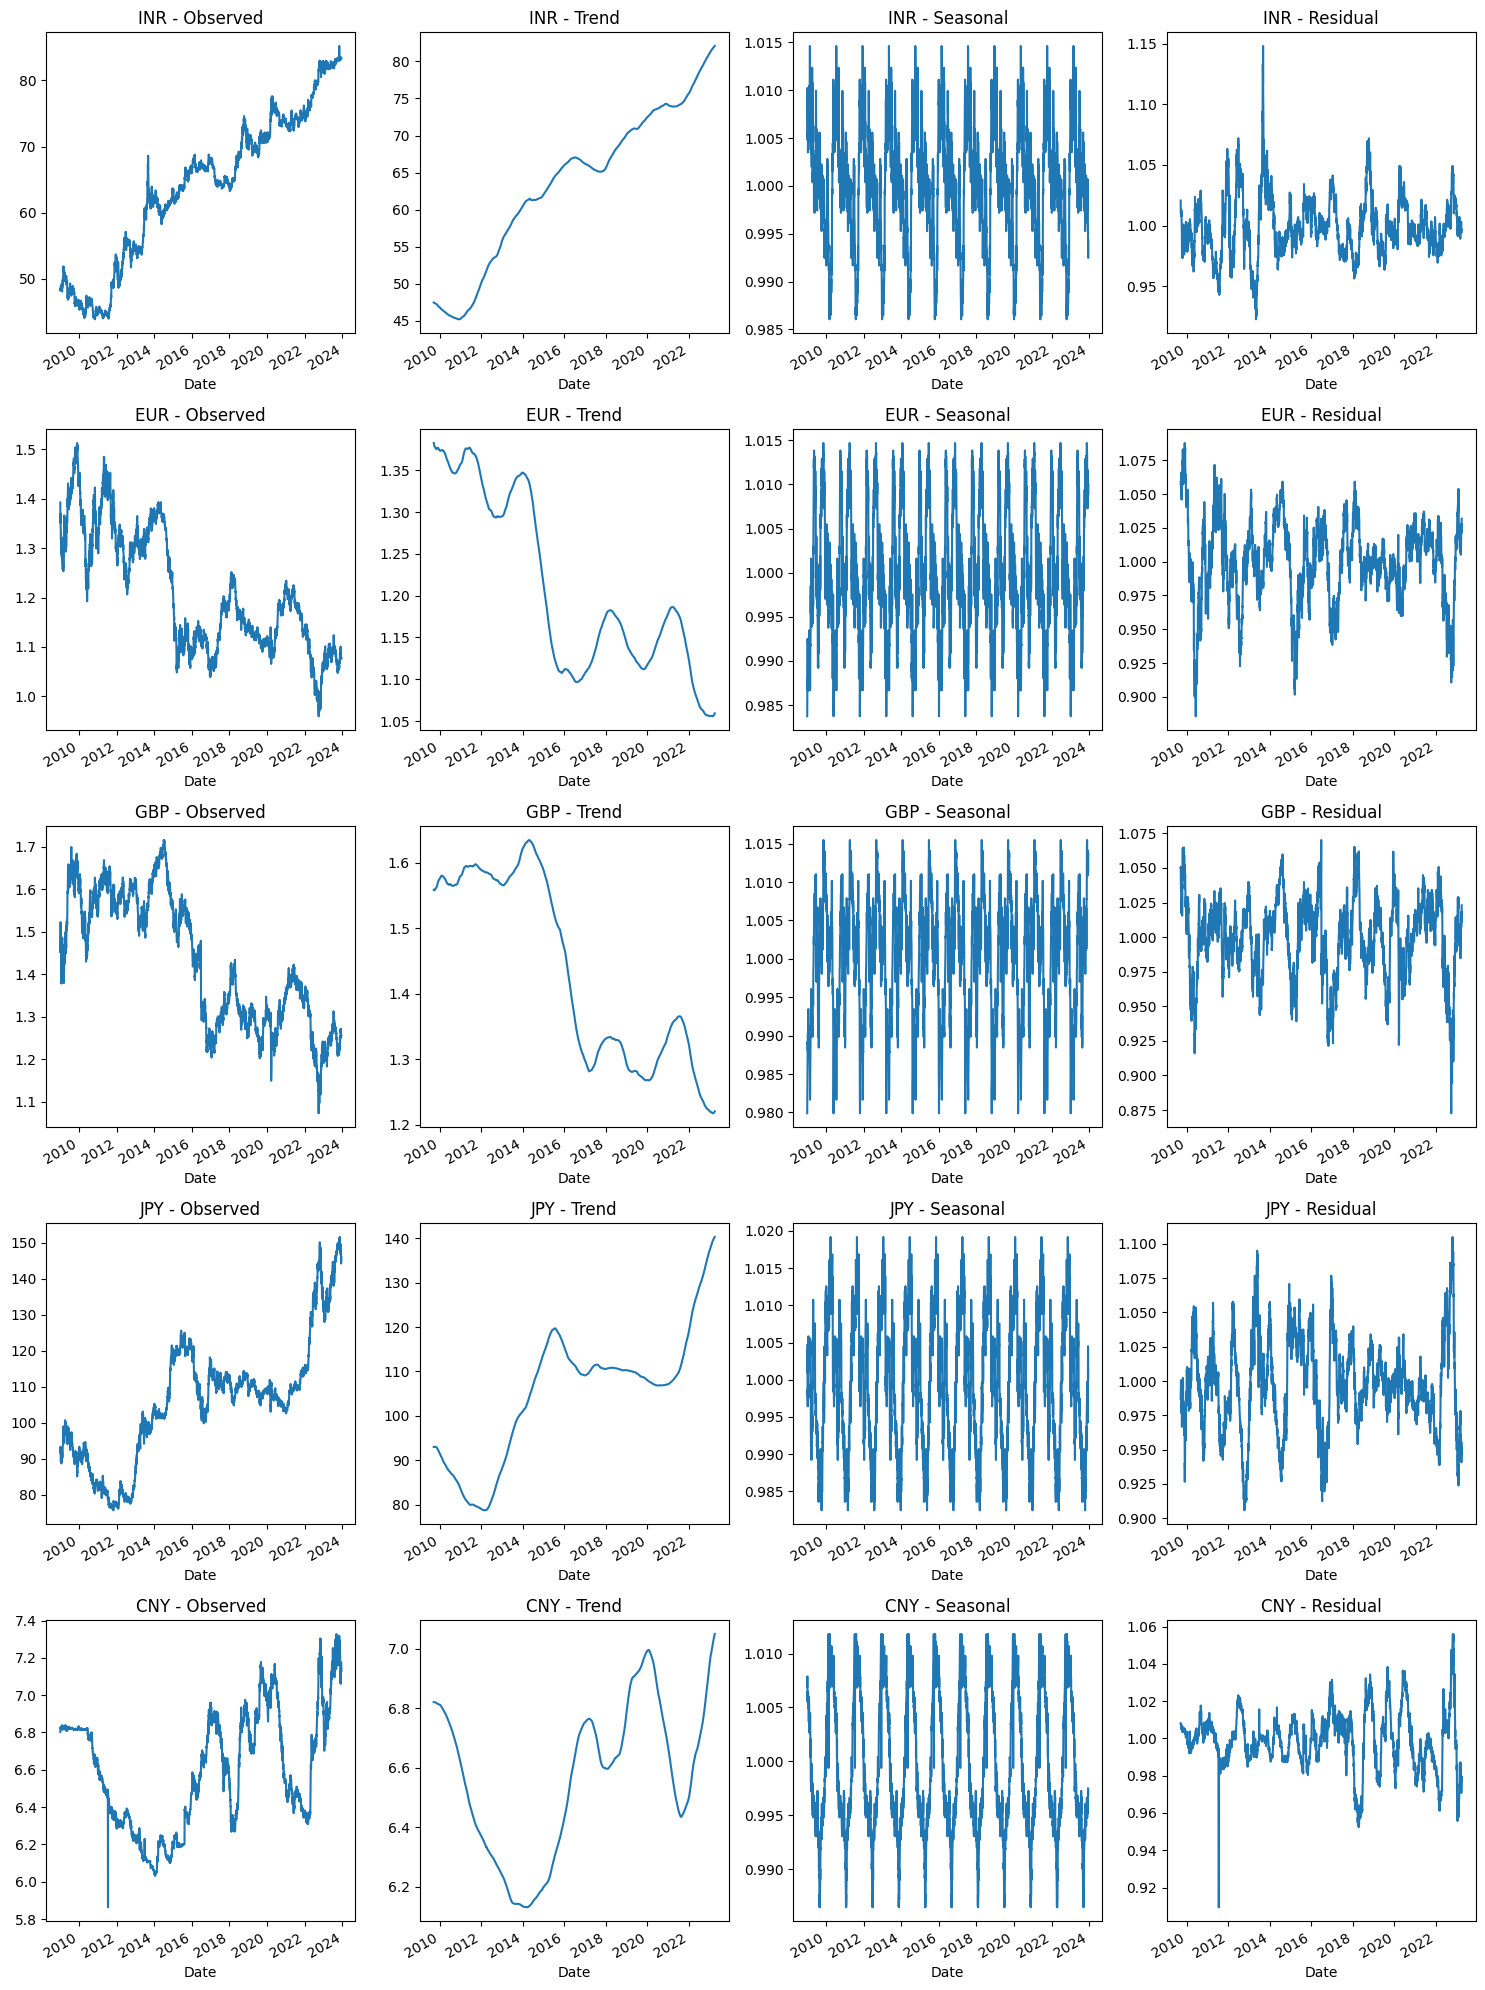

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data = all_currency_data_cleaned

data = data[data['Date'] > '2009-01-01']

df = data.set_index('Date')

# List of currency pairs in your DataFrame
currency_pairs = ['INR', 'EUR', 'GBP', 'JPY', 'CNY']

plt.figure(figsize=(15, 12))

# Set up the figure for subplots
n_pairs = len(currency_pairs)
plt.figure(figsize=(15, 4 * n_pairs))

# Loop through each currency pair
for i, pair in enumerate(currency_pairs, 1):
    series = df[df['Currency_Pair']==pair]['Close'].dropna()  # Drop NaN values

    # Decompose the time series (assuming daily data with annual seasonality)
    decomposition = seasonal_decompose(series, model='multiplicative', period=365)

    # Plotting each component
    plt.subplot(n_pairs, 4, 4 * (i-1) + 1)
    decomposition.observed.plot()
    plt.title(f'{pair} - Observed')
    plt.tight_layout()

    plt.subplot(n_pairs, 4, 4 * (i-1) + 2)
    decomposition.trend.plot()
    plt.title(f'{pair} - Trend')
    plt.tight_layout()

    plt.subplot(n_pairs, 4, 4 * (i-1) + 3)
    decomposition.seasonal.plot()
    plt.title(f'{pair} - Seasonal')
    plt.tight_layout()

    plt.subplot(n_pairs, 4, 4 * (i-1) + 4)
    decomposition.resid.plot()
    plt.title(f'{pair} - Residual')
    plt.tight_layout()

plt.show()

#PART 3 : Feature Engineering

In [50]:
# Creating Lag features
#df3 = all_currency_data_cleaned
df = all_currency_data_cleaned
lag_days = [3, 7]  # You can choose different lags based on your data frequency

def calc_lag (df, lag_days):
  for lag in lag_days:
      df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
  return df

#Calculate moving averages
moving_averages = [10]  # Example window sizes
def calc_ma(df, moving_averages):
  for ma in moving_averages:
    df[f'Close_MA_5'] = df['Close'].shift(1).rolling(window=ma).mean()
  return df



#Calculate the Relative Strength Index (RSI)
def compute_rsi(df, data, window=14):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Shift the series to exclude the current row from the rolling calculation
    up_shifted = up.shift(1)
    down_shifted = down.shift(1)

    gain = up_shifted.rolling(window=window).mean()
    loss = down_shifted.abs().rolling(window=window).mean()

    RS = gain / loss
    x = 100 - (100 / (1 + RS))
    df['RSI'] = x
    return df


'''
#Normalize features
from sklearn.preprocessing import MinMaxScaler
def normalize(df):
  scaler = MinMaxScaler()
  df_scaled = scaler.fit_transform(df[['Close_lag_1', 'Close_MA_5', 'RSI', 'Daily_Return', 'High_Low_Range']])
  df_scaled = pd.DataFrame(df_scaled, columns=['Close_lag_1', 'Close_MA_5', 'RSI', 'Daily_Return', 'High_Low_Range'])
'''

#df3 = all_currency_data_cleaned
df1 = pd.DataFrame()

for curr in currency_pairs:

  df4 = df[df['Currency_Pair']==curr]

  df4 = calc_lag(df4, lag_days)

  df4 = calc_ma(df4, moving_averages)

  df4 = compute_rsi(df4, df4['Close'])

  df1 = pd.concat([df1, df4], axis = 0, ignore_index=False)

all_currency_data_cleaned = df1[df1['Date'] >= '2009-01-01']

all_currency_data_cleaned

<ipython-input-50-b1d6b59c80bc>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-b1d6b59c80bc>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-b1d6b59c80bc>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-b1d6b5

,Date,Open,High,Low,Close,Adj Close,Currency_Pair,Return,Volatility,Close_lag_3,Close_lag_7,Close_MA_5,RSI
23528,2009-01-01,48.0650,48.8250,48.0650,48.0650,48.064999,INR,0.000000,0.110483,48.0170,48.6300,48.02180,47.658839
23529,2009-01-02,48.0650,49.0750,48.0650,48.2450,48.244999,INR,0.003745,0.110500,48.4500,48.0720,48.16360,48.761792
23530,2009-01-05,48.8000,48.8000,48.1960,48.2290,48.229000,INR,-0.000332,0.110503,48.0650,48.6830,48.28430,56.095207
23531,2009-01-06,48.5000,48.7600,48.4500,48.5050,48.505001,INR,0.005723,0.110371,48.0650,48.6830,48.31390,53.871997
23532,2009-01-07,48.5030,48.8380,48.3700,48.5510,48.550999,INR,0.000948,0.110370,48.2450,48.0170,48.30140,57.742042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22221,2023-12-06,7.1456,7.1460,7.1446,7.1456,7.145600,CNY,0.001458,0.085520,7.0754,7.0819,7.09542,38.873025
22222,2023-12-07,7.1446,7.1448,7.1273,7.1446,7.144600,CNY,-0.000140,0.085516,7.0618,7.1303,7.10129,40.536456
22223,2023-12-08,7.1488,7.1653,7.0878,7.1488,7.148800,CNY,0.000588,0.085476,7.1352,7.0638,7.10033,40.829528
22224,2023-12-11,7.1266,7.1872,7.1025,7.1266,7.126600,CNY,-0.003105,0.085492,7.1456,7.0789,7.10663,43.891675


In [51]:
all_currency_data_cleaned

,Date,Open,High,Low,Close,Adj Close,Currency_Pair,Return,Volatility,Close_lag_3,Close_lag_7,Close_MA_5,RSI
23528,2009-01-01,48.0650,48.8250,48.0650,48.0650,48.064999,INR,0.000000,0.110483,48.0170,48.6300,48.02180,47.658839
23529,2009-01-02,48.0650,49.0750,48.0650,48.2450,48.244999,INR,0.003745,0.110500,48.4500,48.0720,48.16360,48.761792
23530,2009-01-05,48.8000,48.8000,48.1960,48.2290,48.229000,INR,-0.000332,0.110503,48.0650,48.6830,48.28430,56.095207
23531,2009-01-06,48.5000,48.7600,48.4500,48.5050,48.505001,INR,0.005723,0.110371,48.0650,48.6830,48.31390,53.871997
23532,2009-01-07,48.5030,48.8380,48.3700,48.5510,48.550999,INR,0.000948,0.110370,48.2450,48.0170,48.30140,57.742042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22221,2023-12-06,7.1456,7.1460,7.1446,7.1456,7.145600,CNY,0.001458,0.085520,7.0754,7.0819,7.09542,38.873025
22222,2023-12-07,7.1446,7.1448,7.1273,7.1446,7.144600,CNY,-0.000140,0.085516,7.0618,7.1303,7.10129,40.536456
22223,2023-12-08,7.1488,7.1653,7.0878,7.1488,7.148800,CNY,0.000588,0.085476,7.1352,7.0638,7.10033,40.829528
22224,2023-12-11,7.1266,7.1872,7.1025,7.1266,7.126600,CNY,-0.003105,0.085492,7.1456,7.0789,7.10663,43.891675


In [52]:
def feature_engg(df, lag_days=[7], moving_averages=[10]):
  df1 = pd.DataFrame()
  df4 = df

  df4 = calc_lag(df4, lag_days)

  df4 = calc_ma(df4, moving_averages)

  df4 = compute_rsi(df4, df4['Close'])

  df1 = pd.concat([df1, df4], axis = 0, ignore_index=False)

  return df1

#PART 4 : Model Creation


##1.Model training

###GBP

In [25]:
currency_pair = 'GBP'
data = all_currency_data_cleaned
other_df = data[data['Currency_Pair'] == 'EUR'][['Date','Close']]
other_df['Other_Close'] = other_df['Close']
other_df.drop('Close', axis =1, inplace = True)


data = data[data['Currency_Pair'] == currency_pair]
# Perform a left merge based on the 'ID' column
data = data.merge(other_df, on='Date', how='left')

#Fill Missing and null values
data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']



# Split the data into train and test
#split_date = '2023-11-01'  # Adjust this date to ensure enough data points in both sets
data = data[ data['Date'] > '2009-01-01']

data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

train_GBP = data.iloc[:int(0.9*data.shape[0]),:]
test_GBP = data.iloc[int(0.9*data.shape[0]):,:]

# Check if test set is too small
if len(test_GBP) < 2:
    raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

# Prepare the training data for Prophet
df_train_GBP = pd.DataFrame({
    'ds': pd.to_datetime(train_GBP['Date']),
    'y': train_GBP['Close'],
    'Open': train_GBP['Open'],
    'High': train_GBP['High'],
    'Low': train_GBP['Low'],
    'Return': train_GBP['Return'],
    'Close_lag_7' : train_GBP['Close_lag_7'],
    'Close_MA_5' : train_GBP['Close_MA_5'],
    'RSI' : train_GBP['RSI'],
    'Volatility': train_GBP['Volatility'],
    'Other_Close':train_GBP['Other_Close']
})

# Define and fit the Prophet model
model_GBP = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

#Adding the regressors
model_GBP.add_regressor('Open')
#model_GBP.add_regressor('High')
#model_GBP.add_regressor('Low')
#model_GBP.add_regressor('Return')
#model_GBP.add_regressor('Volatility')
model_GBP.add_regressor('Other_Close')
model_GBP.add_regressor('Close_lag_7')
model_GBP.add_regressor('Close_MA_5')
model_GBP.add_regressor('RSI')


#Fitting the model
model_GBP.fit(df_train_GBP)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/cb3raz5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/8qkj7n6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6914', 'data', 'file=/tmp/tmpcx1jg0nf/cb3raz5x.json', 'init=/tmp/tmpcx1jg0nf/8qkj7n6j.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modelnjpio9y7/prophet_model-20231213032804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###JPY

In [26]:

# Assuming all_currency_data is defined, and split_date is set
data = all_currency_data_cleaned
currency_pair = 'JPY'
data = data[data['Currency_Pair'] == currency_pair]



#split_date = '2023-01-01'  # Adjust this date to ensure enough data points in both sets
data = data[ data['Date'] > '2009-01-01']

data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

train_JPY = data.iloc[:int(0.9*data.shape[0]),:]
test_JPY = data.iloc[int(0.9*data.shape[0]):,:]

# Prepare the training data for Prophet
df_train_JPY = pd.DataFrame({
    'ds': pd.to_datetime(train_JPY['Date']),
    'y': train_JPY['Close'],
    'Open': train_JPY['Open'],
    'High': train_JPY['High'],
    'Low': train_JPY['Low'],
    'Return': train_JPY['Return'],
    'Close_lag_7' : train_JPY['Close_lag_7'],
    'Close_MA_5' : train_JPY['Close_MA_5'],
    'RSI' : train_JPY['RSI'],
    'Volatility': train_JPY['Volatility']
})

# Define and fit the Prophet model
model_JPY = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

#Adding the regressors
model_JPY.add_regressor('Open')
#model_JPY.add_regressor('High')
#model_JPY.add_regressor('Low')
#model_JPY.add_regressor('Return')
#model_JPY.add_regressor('Volatility')
#model_JPY.add_regressor('Other_Close')
model_JPY.add_regressor('Close_lag_7')
model_JPY.add_regressor('Close_MA_5')
model_JPY.add_regressor('RSI')


#Fitting the model
model_JPY.fit(df_train_JPY)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/wghrv1g6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/ozse7ng0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61244', 'data', 'file=/tmp/tmpcx1jg0nf/wghrv1g6.json', 'init=/tmp/tmpcx1jg0nf/ozse7ng0.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modelyxg6tvod/prophet_model-20231213032806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###INR

In [27]:

# Assuming all_currency_data is defined, and split_date is set
data = all_currency_data_cleaned
currency_pair = 'INR'
data = data[data['Currency_Pair'] == currency_pair]

# Test train split
data = data[ data['Date'] > '2009-01-01']

data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

train_INR = data.iloc[:int(0.9*data.shape[0]),:]
test_INR = data.iloc[int(0.9*data.shape[0]):,:]

# Check if test set is too small
if len(test_INR) < 2:
    raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

# Prepare the training data for Prophet
df_train_INR = pd.DataFrame({
    'ds': pd.to_datetime(train_INR['Date']),
    'y': train_INR['Close'],
    'Open': train_INR['Open'],
    'High': train_INR['High'],
    'Low': train_INR['Low'],
    'Return': train_INR['Return'],
    'Close_lag_7' : train_INR['Close_lag_7'],
    'Close_MA_5' : train_INR['Close_MA_5'],
    'RSI' : train_INR['RSI'],
    'Volatility': train_INR['Volatility']
})

# Define and fit the Prophet model
model_INR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

#Adding the regressors
model_INR.add_regressor('Open')
#model_INR.add_regressor('High')
#model_INR.add_regressor('Low')
#model_INR.add_regressor('Return')
#model_INR.add_regressor('Volatility')
#model_INR.add_regressor('Other_Close')
model_INR.add_regressor('Close_lag_7')
model_INR.add_regressor('Close_MA_5')
model_INR.add_regressor('RSI')


#Fitting the model
model_INR.fit(df_train_INR)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/5gd99ljg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/7j2r7o52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19080', 'data', 'file=/tmp/tmpcx1jg0nf/5gd99ljg.json', 'init=/tmp/tmpcx1jg0nf/7j2r7o52.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modely2rkl9ul/prophet_model-20231213032808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###EUR

In [28]:
currency_pair = 'EUR'
data = all_currency_data_cleaned
other_df = data[data['Currency_Pair'] == 'GBP'][['Date','Close']]
other_df['Other_Close'] = other_df['Close']
other_df.drop('Close', axis =1, inplace = True)


data = data[data['Currency_Pair'] == currency_pair]
# Perform a left merge based on the 'ID' column
data = data.merge(other_df, on='Date', how='left')

#Fill Missing and null values
data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


# Test train split
data = data[ data['Date'] > '2009-01-01']

data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

train_EUR = data.iloc[:int(0.9*data.shape[0]),:]
test_EUR = data.iloc[int(0.9*data.shape[0]):,:]

# Check if test set is too small
if len(test_EUR) < 2:
    raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

# Prepare the training data for Prophet
df_train_EUR = pd.DataFrame({
    'ds': pd.to_datetime(train_EUR['Date']),
    'y': train_EUR['Close'],
    'Open': train_EUR['Open'],
    'High': train_EUR['High'],
    'Low': train_EUR['Low'],
    'Return': train_EUR['Return'],
    'Close_lag_7' : train_EUR['Close_lag_7'],
    'Close_MA_5' : train_EUR['Close_MA_5'],
    'RSI' : train_EUR['RSI'],
    'Volatility': train_EUR['Volatility'],
    'Other_Close':train_EUR['Other_Close']
})

# Define and fit the Prophet model
model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

#Adding the regressors
model_EUR.add_regressor('Open')
#model_EUR.add_regressor('High')
#model_EUR.add_regressor('Low')
#model_EUR.add_regressor('Return')
#model_EUR.add_regressor('Volatility')
#model_EUR.add_regressor('Other_Close')
model_EUR.add_regressor('Close_lag_7')
model_EUR.add_regressor('Close_MA_5')
model_EUR.add_regressor('RSI')


#Fitting the model
model_EUR.fit(df_train_EUR)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/lf_ub_m0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/ujh2ry11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62108', 'data', 'file=/tmp/tmpcx1jg0nf/lf_ub_m0.json', 'init=/tmp/tmpcx1jg0nf/ujh2ry11.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modelnek1hr3w/prophet_model-20231213032811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###CNY

In [29]:
data = all_currency_data_cleaned
currency_pair = 'CNY'  # Example: Use 'EUR' for EURUSD=X
data = data[data['Currency_Pair'] == currency_pair]



# Test train split
data = data[ data['Date'] > '2009-01-01']

data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

train_CNY = data.iloc[:int(0.9*data.shape[0]),:]
test_CNY = data.iloc[int(0.9*data.shape[0]):,:]



# Check if test set is too small
if len(test_CNY) < 2:
    raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

# Prepare the training data for Prophet
df_train_CNY = pd.DataFrame({
    'ds': pd.to_datetime(train_CNY['Date']),
    'y': train_CNY['Close'],
    'Open': train_CNY['Open'],
    'High': train_CNY['High'],
    'Low': train_CNY['Low'],
    'Return': train_CNY['Return'],
    'Close_lag_7' : train_CNY['Close_lag_7'],
    'Close_MA_5' : train_CNY['Close_MA_5'],
    'RSI' : train_CNY['RSI'],
    'Volatility': train_CNY['Volatility']
})

# Define and fit the Prophet model
model_CNY = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

#Adding the regressors
model_CNY.add_regressor('Open')
#model_CNY.add_regressor('High')
#model_CNY.add_regressor('Low')
#model_CNY.add_regressor('Return')
#model_CNY.add_regressor('Volatility')
#model_CNY.add_regressor('Other_Close')
model_CNY.add_regressor('Close_lag_7')
model_CNY.add_regressor('Close_MA_5')
model_CNY.add_regressor('RSI')


#Fitting the model
model_CNY.fit(df_train_CNY)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/soz5s_zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/zp7k4b2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96219', 'data', 'file=/tmp/tmpcx1jg0nf/soz5s_zh.json', 'init=/tmp/tmpcx1jg0nf/zp7k4b2m.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_model_j11k3lc/prophet_model-20231213032814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##2.Model Testing

###GBP

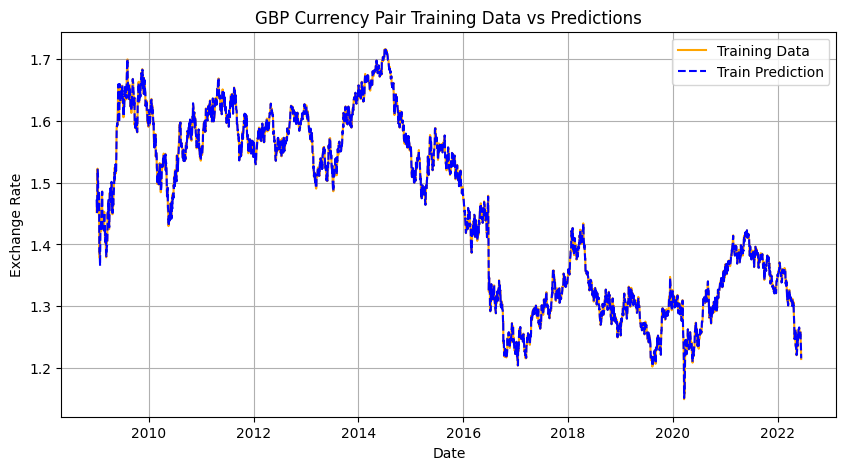

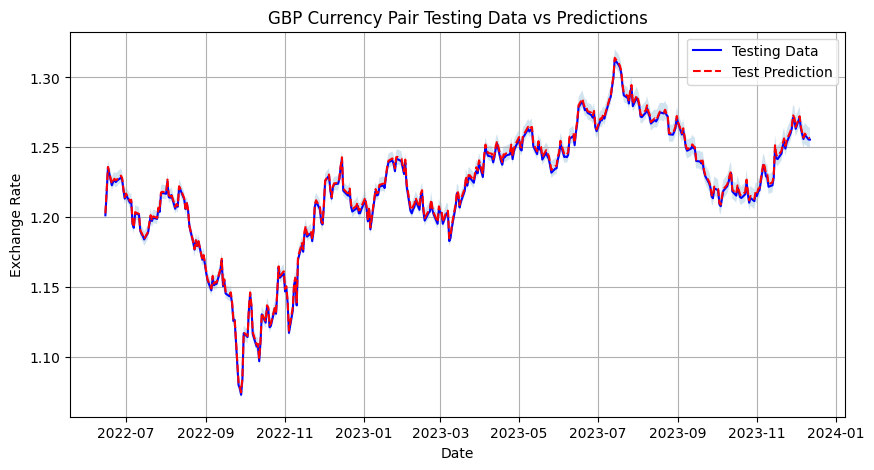

Mean Squared Error (MSE): 2.2471782837648347e-06
Root Mean Squared Error (RMSE): 0.0014990591328446102
Mean Absolute Error (MAE): 0.001420250929838304
Mean Absolute Percentage Error (MAPE): 0.11643677004136395%


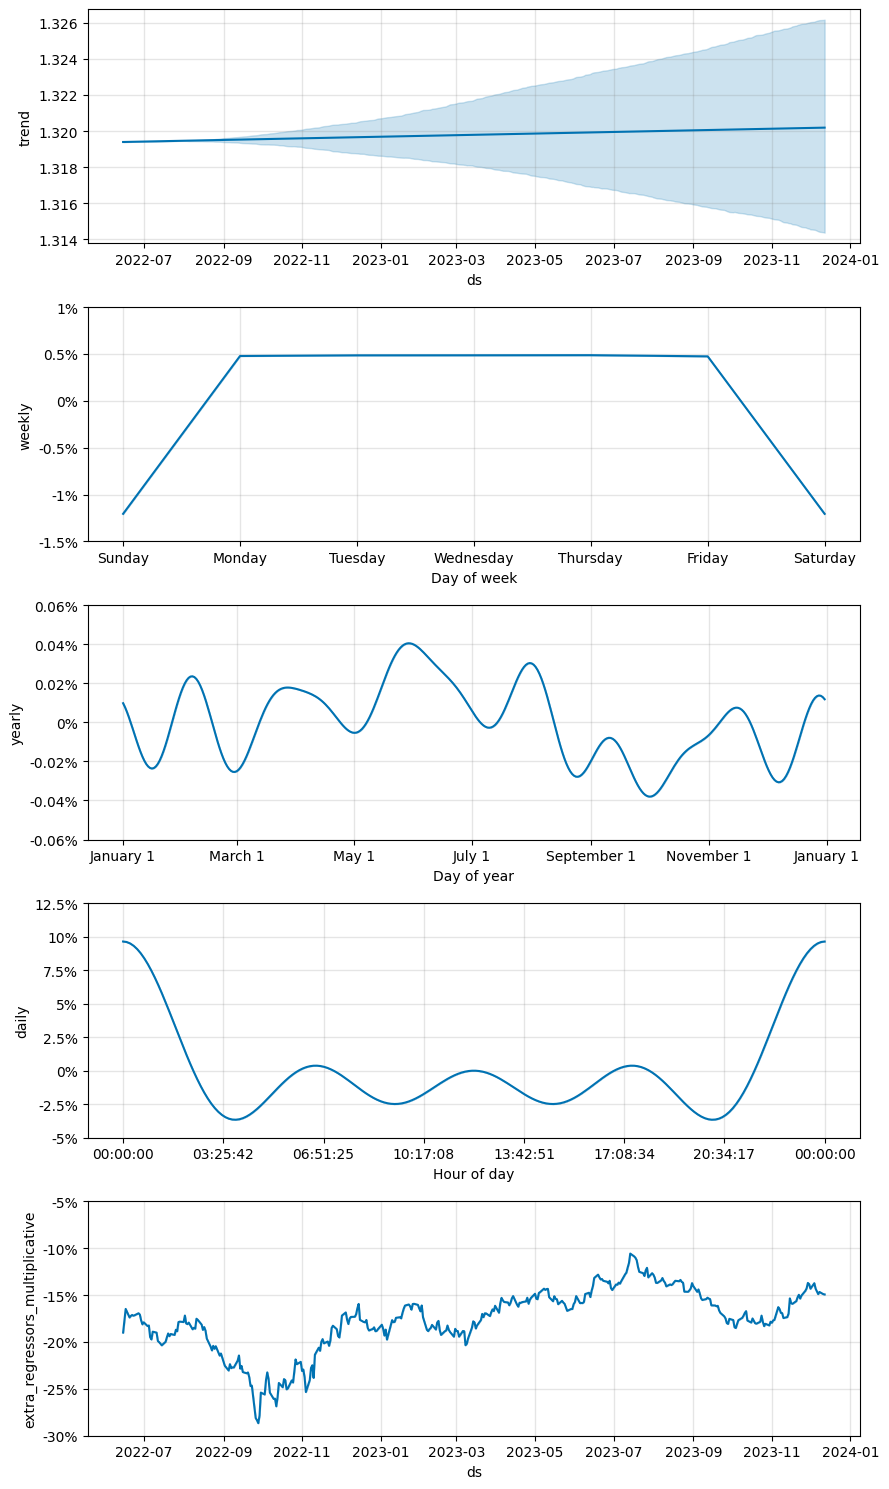

In [30]:
# Checking overfitting

train_predictions = model_GBP.predict(df_train_GBP)


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df_train_GBP['ds'], df_train_GBP['y'], label='Training Data', color='orange')
plt.plot(train_predictions['ds'], train_predictions['yhat'], label='Train Prediction', linestyle='--', color='blue')

plt.title('GBP Currency Pair Training Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the future dataframe for predictions
future = pd.DataFrame({
    'ds': pd.to_datetime(test_GBP['Date']),
    'Open': test_GBP['Open'],
    'High': test_GBP['High'],
    'Low': test_GBP['Low'],
    'Return': test_GBP['Return'],
    'Close_lag_7' : test_GBP['Close_lag_7'],
    'Close_MA_5' : test_GBP['Close_MA_5'],
    'RSI' : test_GBP['RSI'],
    'Volatility': test_GBP['Volatility'],
    'Other_Close':test_GBP['Other_Close']
})
# Check for NaNs in external regressors
if future[['Open', 'High', 'Low', 'Return', 'Volatility','Other_Close']].isna().any().any():
    raise ValueError("NaN values found in future regressors. Please fill or handle NaNs.")

# Predict
forecast = model_GBP.predict(future)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(future['ds'], test_GBP['Close'], label='Testing Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Test Prediction', linestyle='--', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.title('GBP Currency Pair Testing Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

figure = model_GBP.plot_components(forecast)

# Evaluate the model
y_true = test_GBP['Close'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


###JPY

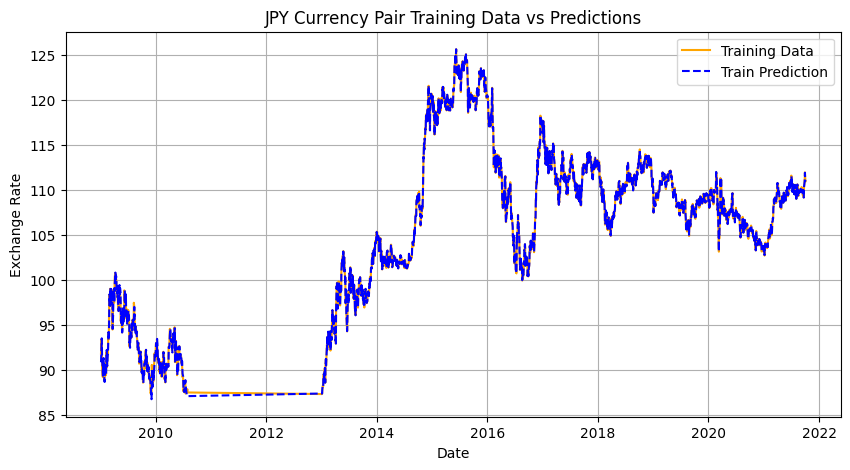

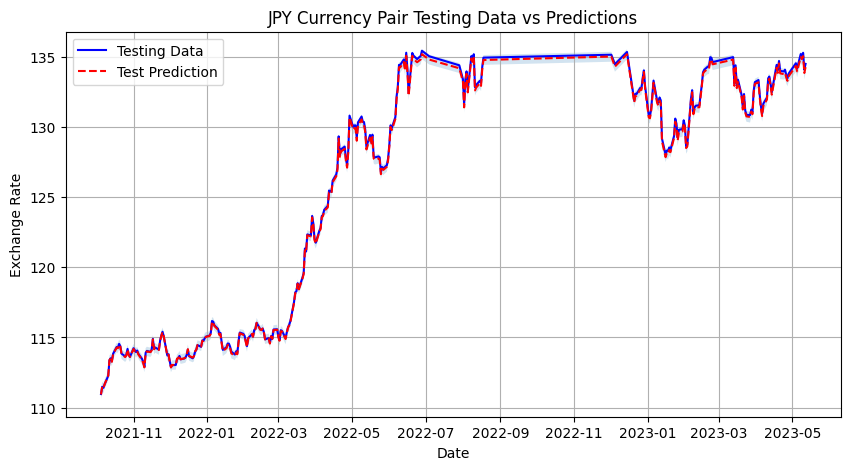

Mean Squared Error (MSE): 0.017202038518862112
Root Mean Squared Error (RMSE): 0.13115654203608035
Mean Absolute Error (MAE): 0.11146408773772012
Mean Absolute Percentage Error (MAPE): 0.08654924896532579%


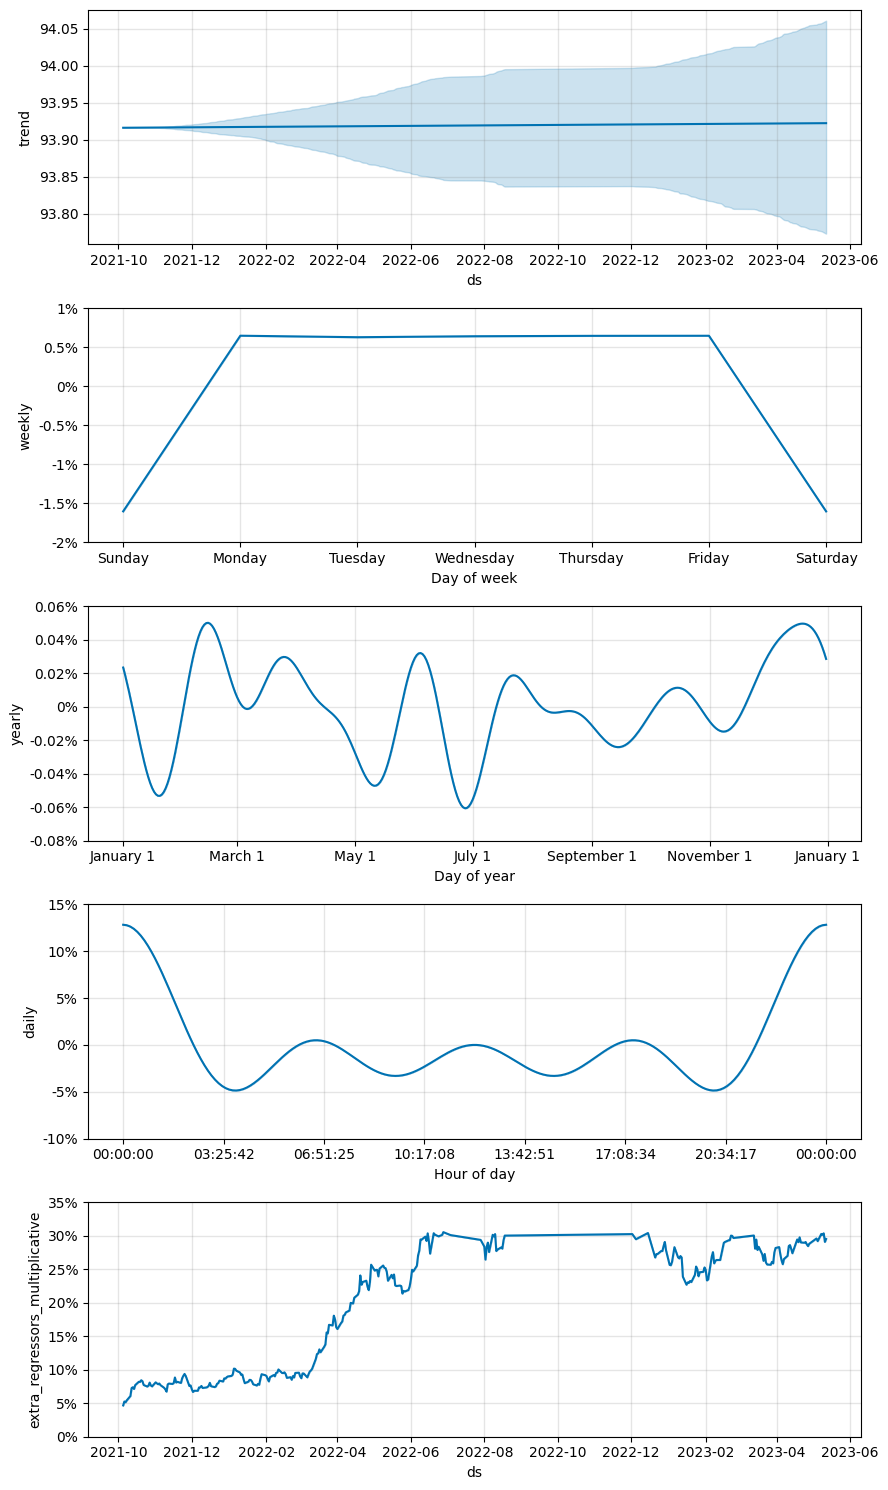

In [31]:
# Checking overfitting

train_predictions = model_JPY.predict(df_train_JPY)


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df_train_JPY['ds'], df_train_JPY['y'], label='Training Data', color='orange')
plt.plot(train_predictions['ds'], train_predictions['yhat'], label='Train Prediction', linestyle='--', color='blue')

plt.title('JPY Currency Pair Training Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the future dataframe for predictions
future = pd.DataFrame({
    'ds': pd.to_datetime(test_JPY['Date']),
    'Open': test_JPY['Open'],
    'High': test_JPY['High'],
    'Low': test_JPY['Low'],
    'Return': test_JPY['Return'],
    'Close_lag_7' : test_JPY['Close_lag_7'],
    'Close_MA_5' : test_JPY['Close_MA_5'],
    'RSI' : test_JPY['RSI'],
    'Volatility': test_JPY['Volatility']
})

# Check for NaNs in external regressors
if future[['Open', 'High', 'Low', 'Return', 'Volatility']].isna().any().any():
    raise ValueError("NaN values found in future regressors. Please fill or handle NaNs.")

# Predict
forecast = model_JPY.predict(future)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(future['ds'], test_JPY['Close'], label='Testing Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Test Prediction', linestyle='--', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.title('JPY Currency Pair Testing Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

figure = model_JPY.plot_components(forecast)


# Evaluate the model
y_true = test_JPY['Close'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


###INR

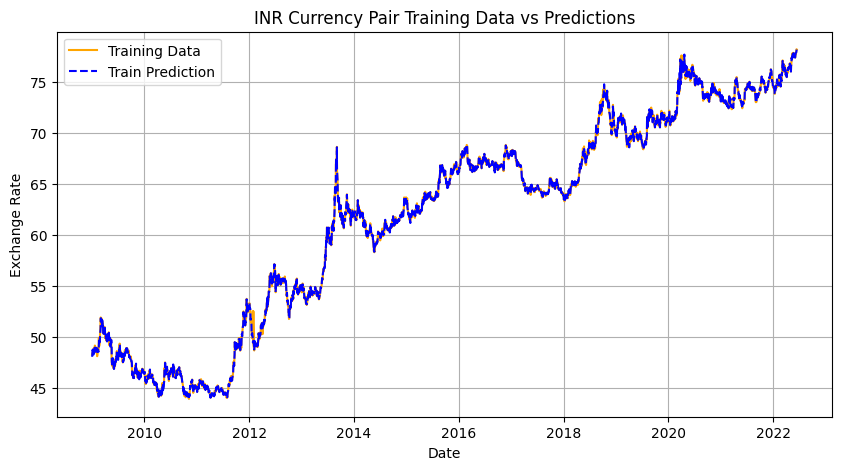

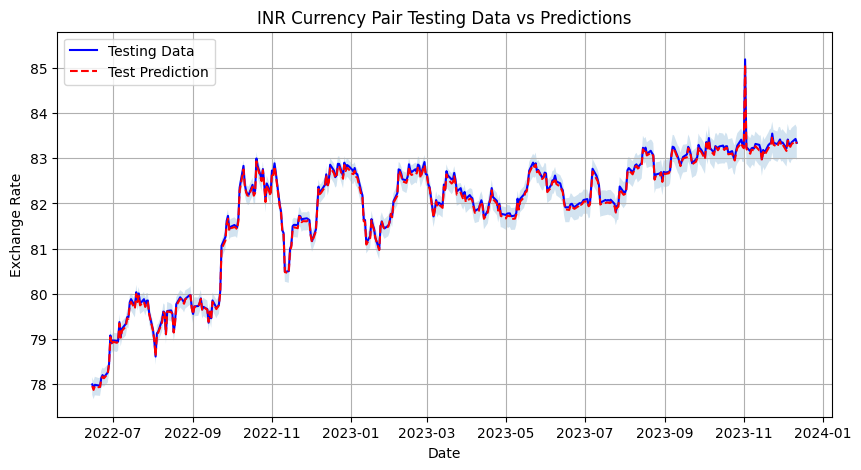

Mean Squared Error (MSE): 0.0019402485546638336
Root Mean Squared Error (RMSE): 0.044048252572194434
Mean Absolute Error (MAE): 0.03941523809753336
Mean Absolute Percentage Error (MAPE): 0.048001035324188424%


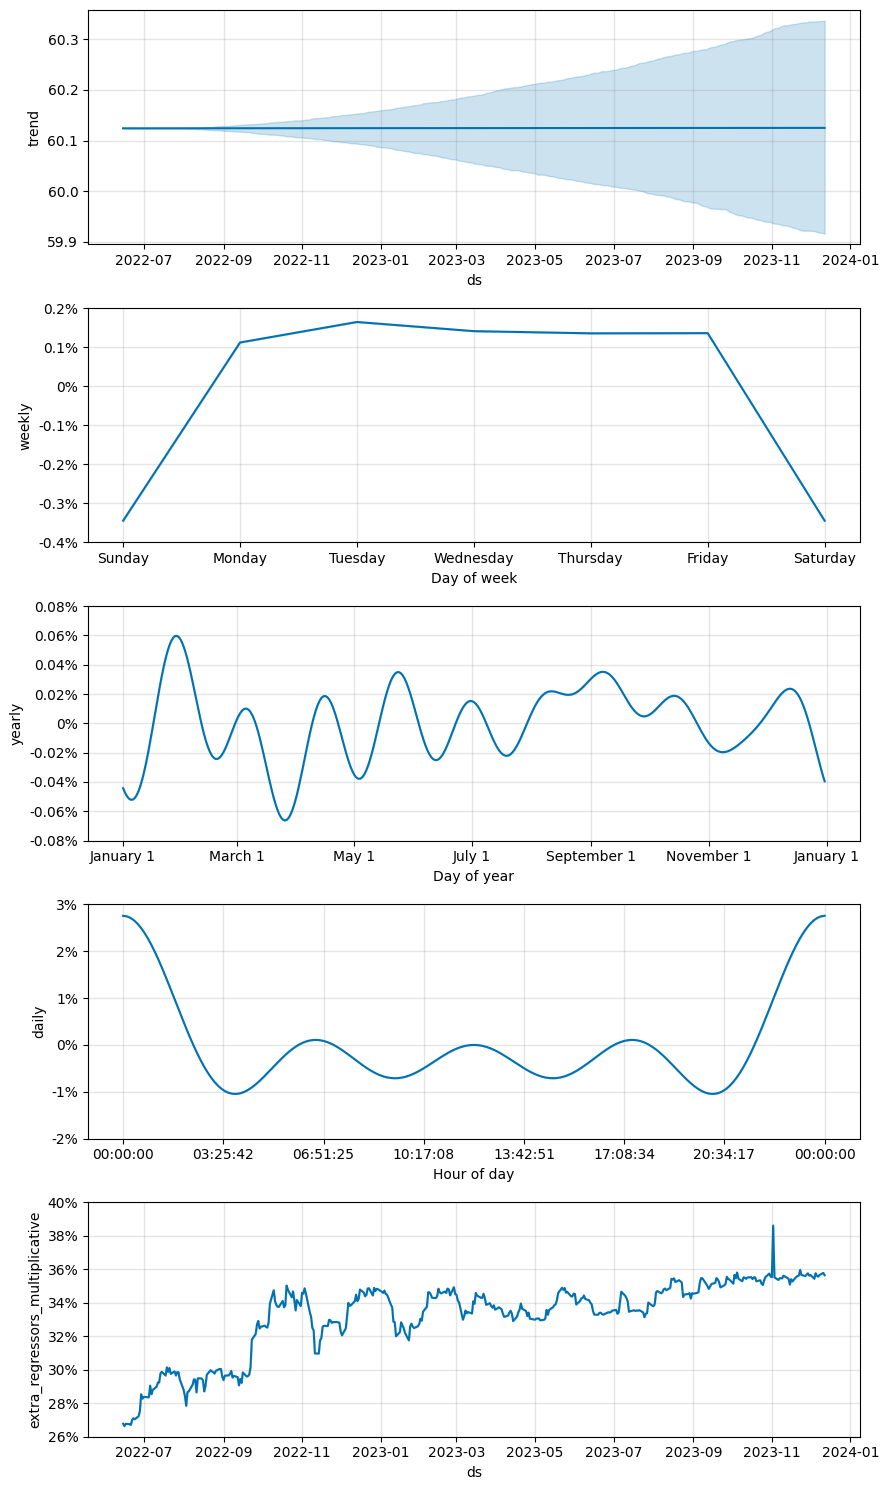

In [32]:
# Checking overfitting

train_predictions = model_INR.predict(df_train_INR)


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df_train_INR['ds'], df_train_INR['y'], label='Training Data', color='orange')
plt.plot(train_predictions['ds'], train_predictions['yhat'], label='Train Prediction', linestyle='--', color='blue')

plt.title('INR Currency Pair Training Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the future dataframe for predictions
future = pd.DataFrame({
    'ds': pd.to_datetime(test_INR['Date']),
    'Open': test_INR['Open'],
    'High': test_INR['High'],
    'Low': test_INR['Low'],
    'Return': test_INR['Return'],
    'Close_lag_7' : test_INR['Close_lag_7'],
    'Close_MA_5' : test_INR['Close_MA_5'],
    'RSI' : test_INR['RSI'],
    'Volatility': test_INR['Volatility']
})


# Check for NaNs in external regressors
if future[['Open', 'High', 'Low', 'Return', 'Volatility']].isna().any().any():
    raise ValueError("NaN values found in future regressors. Please fill or handle NaNs.")

# Predict
forecast = model_INR.predict(future)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(future['ds'], test_INR['Close'], label='Testing Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Test Prediction', linestyle='--', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.title('INR Currency Pair Testing Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

figure = model_INR.plot_components(forecast)


# Evaluate the model
y_true = test_INR['Close'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


###EUR

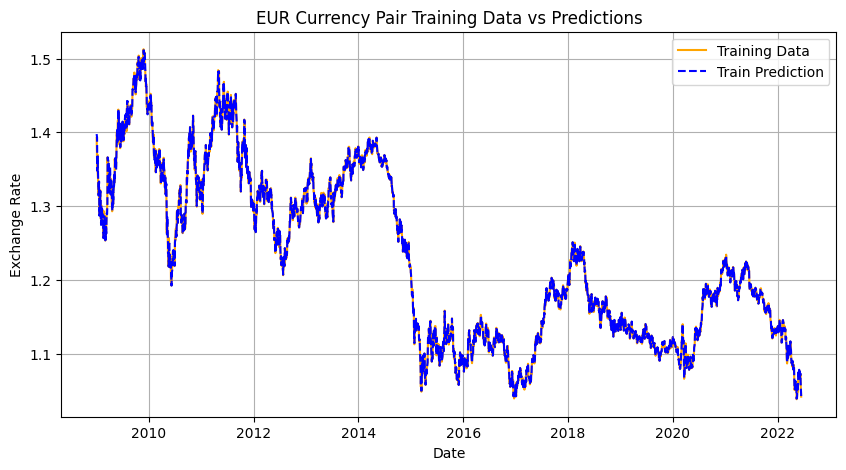

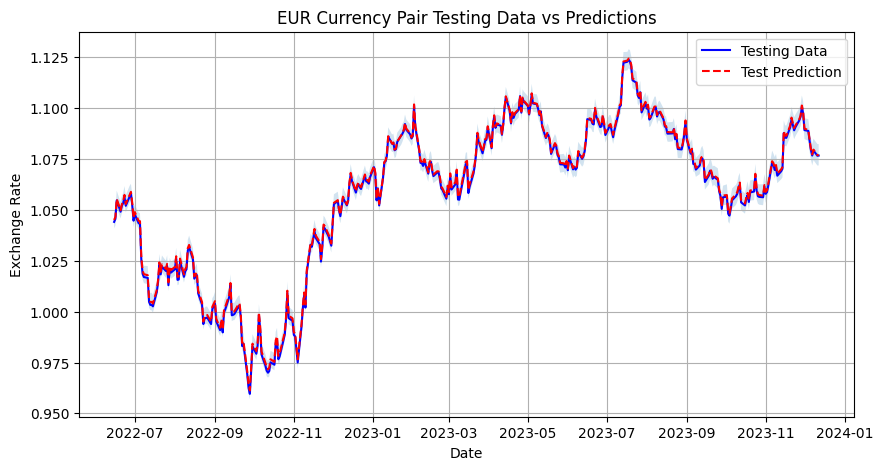

Mean Squared Error (MSE): 8.912455767409165e-07
Root Mean Squared Error (RMSE): 0.0009440580367439899
Mean Absolute Error (MAE): 0.0008819560720127017
Mean Absolute Percentage Error (MAPE): 0.08440306776496981%


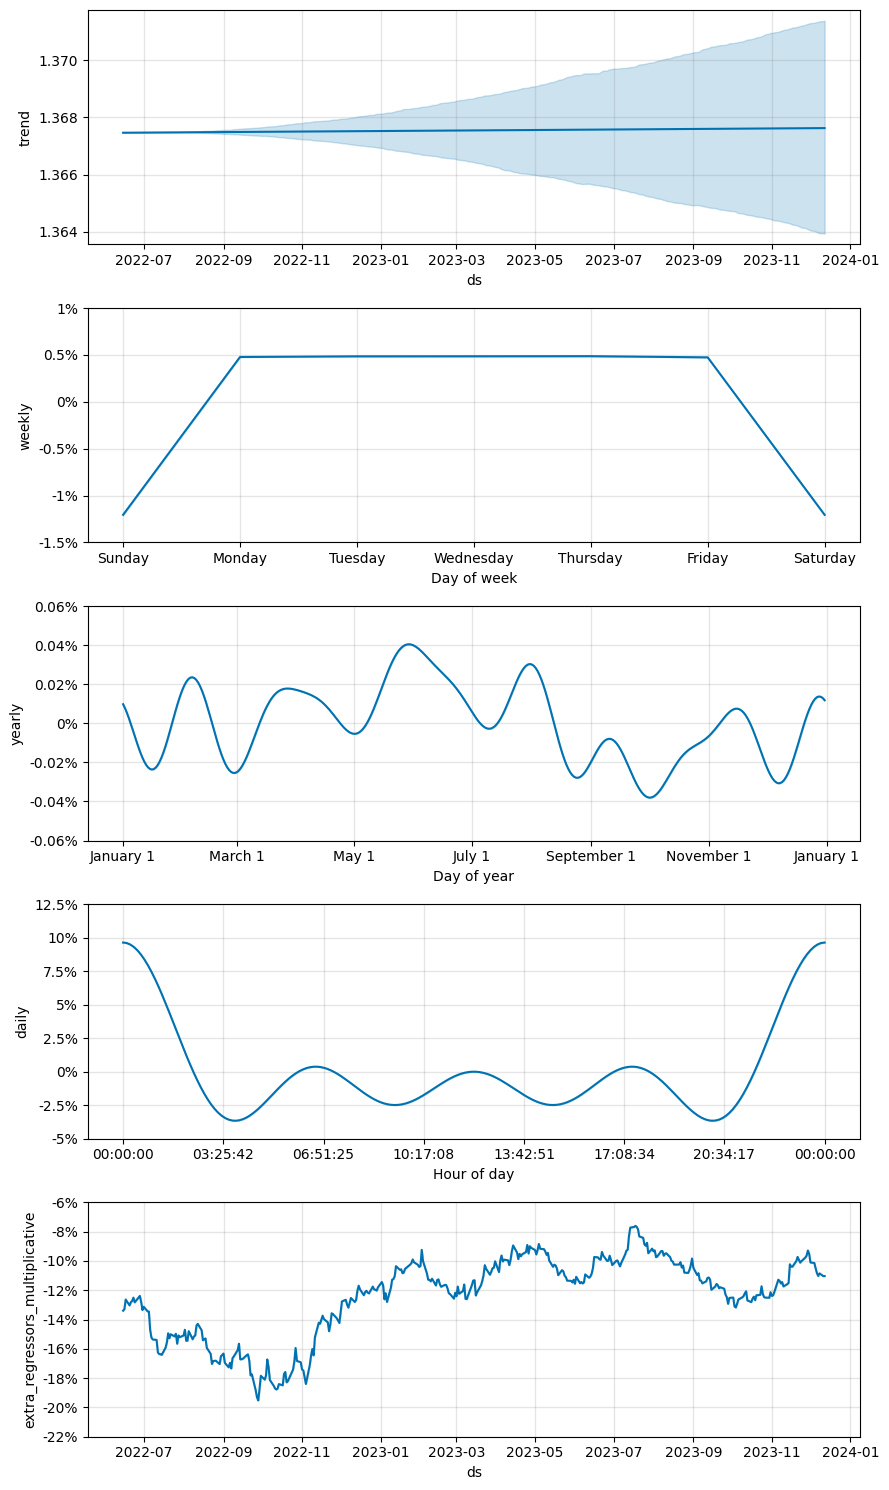

In [33]:
# Checking overfitting

train_predictions = model_EUR.predict(df_train_EUR)


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df_train_EUR['ds'], df_train_EUR['y'], label='Training Data', color='orange')
plt.plot(train_predictions['ds'], train_predictions['yhat'], label='Train Prediction', linestyle='--', color='blue')

plt.title('EUR Currency Pair Training Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the future dataframe for predictions
future = pd.DataFrame({
    'ds': pd.to_datetime(test_EUR['Date']),
    'Open': test_EUR['Open'],
    'High': test_EUR['High'],
    'Low': test_EUR['Low'],
    'Return': test_EUR['Return'],
    'Close_lag_7' : test_EUR['Close_lag_7'],
    'Close_MA_5' : test_EUR['Close_MA_5'],
    'RSI' : test_EUR['RSI'],
    'Volatility': test_EUR['Volatility'],
    'Other_Close':test_EUR['Other_Close']
})

# Check for NaNs in external regressors
if future[['Open', 'High', 'Low', 'Return', 'Volatility','Other_Close']].isna().any().any():
    raise ValueError("NaN values found in future regressors. Please fill or handle NaNs.")

# Predict
forecast = model_EUR.predict(future)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(future['ds'], test_EUR['Close'], label='Testing Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Test Prediction', linestyle='--', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.title('EUR Currency Pair Testing Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

figure = model_GBP.plot_components(forecast)

# Evaluate the model
y_true = test_EUR['Close'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


###CNY

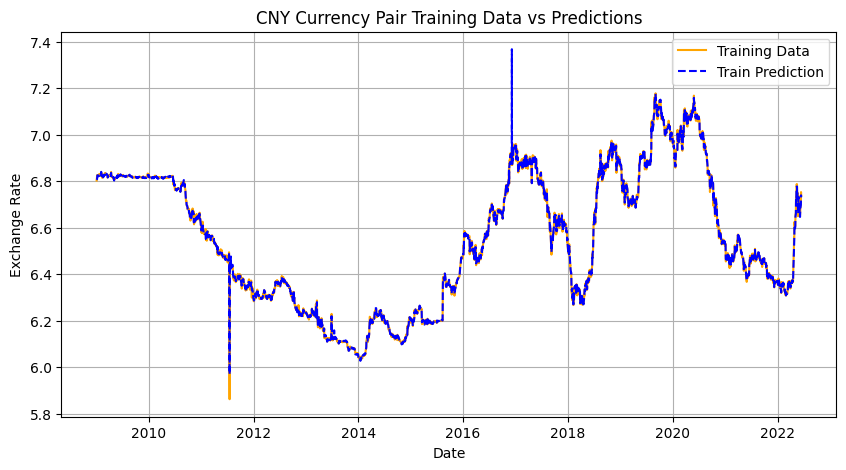

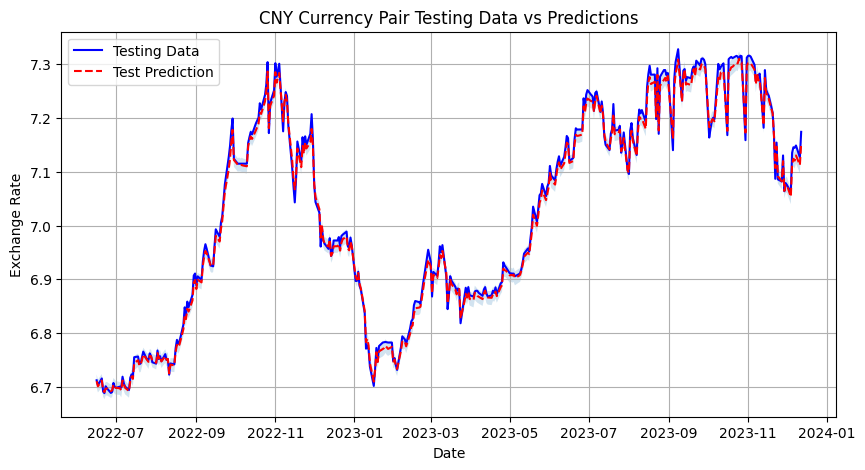

Mean Squared Error (MSE): 0.00010399875089339502
Root Mean Squared Error (RMSE): 0.010197977784511742
Mean Absolute Error (MAE): 0.008506503013659954
Mean Absolute Percentage Error (MAPE): 0.12005975063147506%


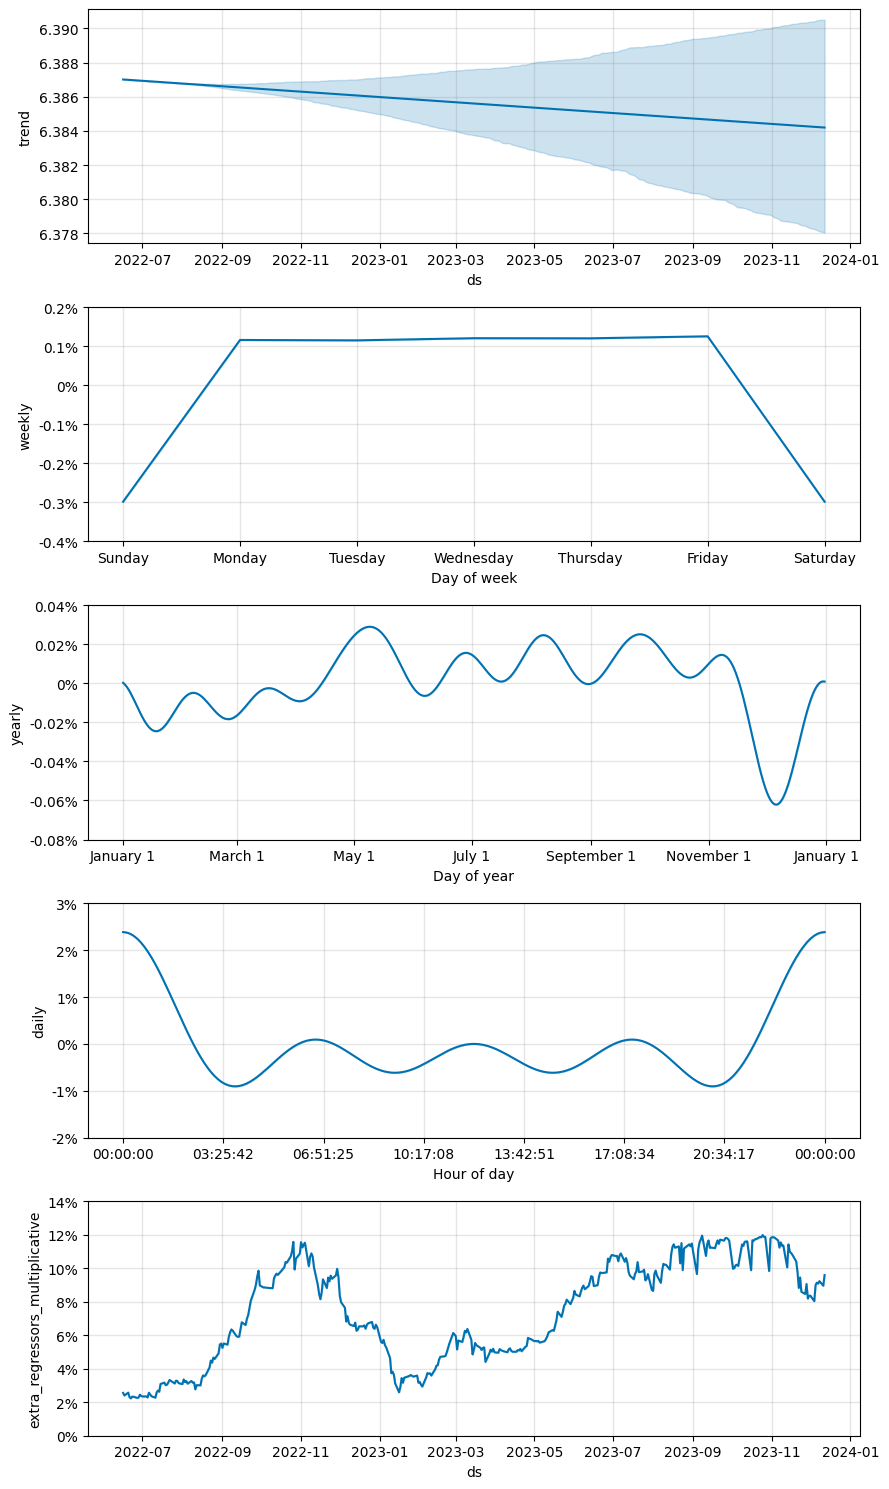

In [34]:
# Checking overfitting
currency_pair = 'CNY'
train_predictions = model_CNY.predict(df_train_CNY)


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df_train_CNY['ds'], df_train_CNY['y'], label='Training Data', color='orange')
plt.plot(train_predictions['ds'], train_predictions['yhat'], label='Train Prediction', linestyle='--', color='blue')

plt.title(f'{currency_pair} Currency Pair Training Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the future dataframe for predictions
future = pd.DataFrame({
    'ds': pd.to_datetime(test_CNY['Date']),
    'Open': test_CNY['Open'],
    'High': test_CNY['High'],
    'Low': test_CNY['Low'],
    'Return': test_CNY['Return'],
    'Close_lag_7' : test_CNY['Close_lag_7'],
    'Close_MA_5' : test_CNY['Close_MA_5'],
    'RSI' : test_CNY['RSI'],
    'Volatility': test_CNY['Volatility']
})

# Check for NaNs in external regressors
if future[['Open', 'High', 'Low', 'Return', 'Volatility']].isna().any().any():
    raise ValueError("NaN values found in future regressors. Please fill or handle NaNs.")

# Predict
forecast = model_CNY.predict(future)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(future['ds'], test_CNY['Close'], label='Testing Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Test Prediction', linestyle='--', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.title(f'{currency_pair} Currency Pair Testing Data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

figure = model_CNY.plot_components(forecast)


# Evaluate the model
y_true = test_CNY['Close'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


#PART 5 : Forecasting

For forecasting, we will take the entire data as training set and forecast into the future for 30 days

###1.EUR forecasting

In [35]:
def EURO(all_currency_data):
  currency_pair = 'EUR'
  data = all_currency_data
  other_df = data[data['Currency_Pair'] == 'GBP'][['Date','Close']]
  other_df['Other_Close'] = other_df['Close']
  other_df.drop('Close', axis =1, inplace = True)


  data = data[data['Currency_Pair'] == currency_pair]
  # Perform a left merge based on the 'ID' column
  data = data.merge(other_df, on='Date', how='left')

  #Fill Missing and null values
  data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


  # Test train split
  data = data[ data['Date'] > '2009-01-01']

  data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

  # Check if test set is too small
  if len(test_EUR) < 2:
      raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

  # Prepare the training data for Prophet
  df_train_EUR = pd.DataFrame({
      'ds': pd.to_datetime(data['Date']),
      'y': data['Close'],
      'Open': data['Open'],
      'Close_lag_7' : data['Close_lag_7'],
      'Close_MA_5' : data['Close_MA_5'],
      'RSI' : data['RSI']
  })


  # Define and fit the Prophet model
  model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

  #Adding the regressors
  model_EUR.add_regressor('Open')
  #model_EUR.add_regressor('High')
  #model_EUR.add_regressor('Low')
  #model_EUR.add_regressor('Return')
  #model_EUR.add_regressor('Volatility')
  #model_EUR.add_regressor('Other_Close')
  model_EUR.add_regressor('Close_lag_7')
  model_EUR.add_regressor('Close_MA_5')
  model_EUR.add_regressor('RSI')


  #Fitting the model
  model_EUR.fit(df_train_EUR)



  def generate_future_weekdays(start_date, num_days):
      future_dates = []
      current_date = start_date
      while len(future_dates) < num_days:
          current_date += pd.Timedelta(days=1)
          # Check if it's a weekday (0=Monday, 6=Sunday)
          if current_date.weekday() < 5:
              future_dates.append(current_date)
      return future_dates

  last_date = df_train_EUR['ds'].iloc[-1]
  future_dates = generate_future_weekdays(last_date, 7)
  future = pd.DataFrame({'ds' : future_dates})

  # Assume the last known 'Open' price is the last known 'Close' price
  last_known_open = data['Close'].iloc[-1]

  # DataFrame to store the predictions
  predictions_EUR = pd.DataFrame({
      'Date': future_dates,
      'Close': [0]*len(future_dates),
      'Close_lag_7' : [0]*len(future_dates),
      'Close_MA_5' : [0]*len(future_dates),
      'RSI' : [0]*len(future_dates),
      'High' : [0]*len(future_dates),
      'Low' : [0]*len(future_dates)
    })

  predictions_EUR = pd.concat([data[['Date','Close','Close_lag_7','Close_MA_5', 'RSI', 'High', 'Low']][-200:], predictions_EUR], axis = 0, ignore_index=False,)
  predictions_EUR.reset_index(inplace = True, drop = True)


  # Iteratively predict the next day's 'Close' and set it as the next 'Open'
  for i in range(len(future_dates)):
      # Set the 'Open' price for the current day
      predictions_EUR = feature_engg(predictions_EUR, [7], [10])
      df = predictions_EUR[-(len(future_dates)):]
      df.reset_index(inplace =True, drop = True)
      future.at[i, 'Open'] = last_known_open
      future['RSI'] = df['RSI']
      future['Close_lag_7'] = df['Close_lag_7']
      future['Close_MA_5'] = df['Close_MA_5']

      # Make the prediction for the current day
      forecast = model_EUR.predict(future.iloc[[i]])


      df.at[i, 'Close'] = forecast['yhat'].iloc[0]
      df.at[i, 'High'] = forecast['yhat_upper'].iloc[0]
      df.at[i, 'Low'] = forecast['yhat_lower'].iloc[0]

      predictions_EUR = predictions_EUR[:-(len(future_dates))]
      predictions_EUR = pd.concat([predictions_EUR, df], axis = 0, ignore_index = True)


      # Get the predicted 'Close' price
      predicted_close = forecast['yhat'].iloc[0]

      # Update the last known 'Open' price
      last_known_open = predicted_close

  return predictions_EUR[-20:]

In [36]:
predictions_EUR = EURO(all_currency_data_cleaned)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/vtsj_grn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/2ui21765.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99977', 'data', 'file=/tmp/tmpcx1jg0nf/vtsj_grn.json', 'init=/tmp/tmpcx1jg0nf/2ui21765.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modelo44iagq5/prophet_model-20231213032834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##2.GBP Forecasting

In [37]:
def GBP(all_currency_data, predictions_EUR):
  currency_pair = 'GBP'
  data = all_currency_data
  other_df = data[data['Currency_Pair'] == 'EUR'][['Date','Close']]
  other_df['Other_Close'] = other_df['Close']
  other_df.drop('Close', axis =1, inplace = True)


  data = data[data['Currency_Pair'] == currency_pair]
  # Perform a left merge based on the 'ID' column
  data = data.merge(other_df, on='Date', how='left')

  #Fill Missing and null values
  data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


  # Test train split
  data = data[ data['Date'] > '2009-01-01']

  data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

  # Check if test set is too small
  if len(test_EUR) < 2:
      raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

  # Prepare the training data for Prophet
  df_train_EUR = pd.DataFrame({
      'ds': pd.to_datetime(data['Date']),
      'y': data['Close'],
      'Open': data['Open'],
      'Close_lag_7' : data['Close_lag_7'],
      'Close_MA_5' : data['Close_MA_5'],
      'RSI' : data['RSI'],
      'Other_Close' : data['Other_Close']
  })


  # Define and fit the Prophet model
  model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

  #Adding the regressors
  model_EUR.add_regressor('Open')
  #model_EUR.add_regressor('High')
  #model_EUR.add_regressor('Low')
  #model_EUR.add_regressor('Return')
  #model_EUR.add_regressor('Volatility')
  model_EUR.add_regressor('Other_Close')
  model_EUR.add_regressor('Close_lag_7')
  model_EUR.add_regressor('Close_MA_5')
  model_EUR.add_regressor('RSI')


  #Fitting the model
  model_EUR.fit(df_train_EUR)



  def generate_future_weekdays(start_date, num_days):
      future_dates = []
      current_date = start_date
      while len(future_dates) < num_days:
          current_date += pd.Timedelta(days=1)
          # Check if it's a weekday (0=Monday, 6=Sunday)
          if current_date.weekday() < 5:
              future_dates.append(current_date)
      return future_dates

  last_date = df_train_EUR['ds'].iloc[-1]
  future_dates = generate_future_weekdays(last_date, 7)
  future = pd.DataFrame({'ds' : future_dates})

  # Assume the last known 'Open' price is the last known 'Close' price
  last_known_open = data['Close'].iloc[-1]
  other_close = predictions_EUR['Close'][-(len(future_dates)):]
  # DataFrame to store the predictions
  predictions_GBP = pd.DataFrame({
      'Date': future_dates,
      'Close': [0]*len(future_dates),
      'Close_lag_7' : [0]*len(future_dates),
      'Close_MA_5' : [0]*len(future_dates),
      'RSI' : [0]*len(future_dates),
      'High' : [0]*len(future_dates),
      'Low' : [0]*len(future_dates),
      'Other_Close' : other_close
    })

  predictions_GBP = pd.concat([data[['Date','Close','Close_lag_7','Close_MA_5', 'RSI', 'High', 'Low', 'Other_Close']][-200:], predictions_GBP], axis = 0, ignore_index=False,)
  predictions_GBP.reset_index(inplace = True, drop = True)


  # Iteratively predict the next day's 'Close' and set it as the next 'Open'
  for i in range(len(future_dates)):
      # Set the 'Open' price for the current day
      predictions_GBP = feature_engg(predictions_GBP, [7], [10])
      df = predictions_GBP[-(len(future_dates)):]
      df.reset_index(inplace =True, drop = True)
      future.at[i, 'Open'] = last_known_open
      future['RSI'] = df['RSI']
      future['Close_lag_7'] = df['Close_lag_7']
      future['Close_MA_5'] = df['Close_MA_5']
      future['Other_Close'] = df['Other_Close']

      # Make the prediction for the current day
      forecast = model_EUR.predict(future.iloc[[i]])


      df.at[i, 'Close'] = forecast['yhat'].iloc[0]
      df.at[i, 'High'] = forecast['yhat_upper'].iloc[0]
      df.at[i, 'Low'] = forecast['yhat_lower'].iloc[0]

      predictions_GBP = predictions_GBP[:-(len(future_dates))]
      predictions_GBP = pd.concat([predictions_GBP, df], axis = 0, ignore_index = True)


      # Get the predicted 'Close' price
      predicted_close = forecast['yhat'].iloc[0]

      # Update the last known 'Open' price
      last_known_open = predicted_close

  return predictions_GBP[-20:]

##3.JPY Forecasting

In [38]:
def JPY(all_currency_data):
  currency_pair = 'JPY'
  data = all_currency_data
  other_df = data[data['Currency_Pair'] == 'GBP'][['Date','Close']]
  other_df['Other_Close'] = other_df['Close']
  other_df.drop('Close', axis =1, inplace = True)


  data = data[data['Currency_Pair'] == currency_pair]
  # Perform a left merge based on the 'ID' column
  data = data.merge(other_df, on='Date', how='left')

  #Fill Missing and null values
  data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


  # Test train split
  data = data[ data['Date'] > '2009-01-01']

  data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

  # Check if test set is too small
  if len(test_EUR) < 2:
      raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

  # Prepare the training data for Prophet
  df_train_EUR = pd.DataFrame({
      'ds': pd.to_datetime(data['Date']),
      'y': data['Close'],
      'Open': data['Open'],
      'Close_lag_7' : data['Close_lag_7'],
      'Close_MA_5' : data['Close_MA_5'],
      'RSI' : data['RSI']
  })


  # Define and fit the Prophet model
  model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

  #Adding the regressors
  model_EUR.add_regressor('Open')
  #model_EUR.add_regressor('High')
  #model_EUR.add_regressor('Low')
  #model_EUR.add_regressor('Return')
  #model_EUR.add_regressor('Volatility')
  #model_EUR.add_regressor('Other_Close')
  model_EUR.add_regressor('Close_lag_7')
  model_EUR.add_regressor('Close_MA_5')
  model_EUR.add_regressor('RSI')


  #Fitting the model
  model_EUR.fit(df_train_EUR)



  def generate_future_weekdays(start_date, num_days):
      future_dates = []
      current_date = start_date
      while len(future_dates) < num_days:
          current_date += pd.Timedelta(days=1)
          # Check if it's a weekday (0=Monday, 6=Sunday)
          if current_date.weekday() < 5:
              future_dates.append(current_date)
      return future_dates

  last_date = df_train_EUR['ds'].iloc[-1]
  future_dates = generate_future_weekdays(last_date, 7)
  future = pd.DataFrame({'ds' : future_dates})

  # Assume the last known 'Open' price is the last known 'Close' price
  last_known_open = data['Close'].iloc[-1]

  # DataFrame to store the predictions
  predictions_EUR = pd.DataFrame({
      'Date': future_dates,
      'Close': [0]*len(future_dates),
      'Close_lag_7' : [0]*len(future_dates),
      'Close_MA_5' : [0]*len(future_dates),
      'RSI' : [0]*len(future_dates),
      'High' : [0]*len(future_dates),
      'Low' : [0]*len(future_dates)
    })

  predictions_EUR = pd.concat([data[['Date','Close','Close_lag_7','Close_MA_5', 'RSI', 'High', 'Low']][-200:], predictions_EUR], axis = 0, ignore_index=False,)
  predictions_EUR.reset_index(inplace = True, drop = True)


  # Iteratively predict the next day's 'Close' and set it as the next 'Open'
  for i in range(len(future_dates)):
      # Set the 'Open' price for the current day
      predictions_EUR = feature_engg(predictions_EUR, [7], [10])
      df = predictions_EUR[-(len(future_dates)):]
      df.reset_index(inplace =True, drop = True)
      future.at[i, 'Open'] = last_known_open
      future['RSI'] = df['RSI']
      future['Close_lag_7'] = df['Close_lag_7']
      future['Close_MA_5'] = df['Close_MA_5']

      # Make the prediction for the current day
      forecast = model_EUR.predict(future.iloc[[i]])


      df.at[i, 'Close'] = forecast['yhat'].iloc[0]
      df.at[i, 'High'] = forecast['yhat_upper'].iloc[0]
      df.at[i, 'Low'] = forecast['yhat_lower'].iloc[0]

      predictions_EUR = predictions_EUR[:-(len(future_dates))]
      predictions_EUR = pd.concat([predictions_EUR, df], axis = 0, ignore_index = True)


      # Get the predicted 'Close' price
      predicted_close = forecast['yhat'].iloc[0]

      # Update the last known 'Open' price
      last_known_open = predicted_close

  return predictions_EUR[-20:]

##4.INR Forecasting

In [39]:
def INR(all_currency_data):
  currency_pair = 'INR'
  data = all_currency_data
  other_df = data[data['Currency_Pair'] == 'GBP'][['Date','Close']]
  other_df['Other_Close'] = other_df['Close']
  other_df.drop('Close', axis =1, inplace = True)


  data = data[data['Currency_Pair'] == currency_pair]
  # Perform a left merge based on the 'ID' column
  data = data.merge(other_df, on='Date', how='left')

  #Fill Missing and null values
  data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


  # Test train split
  data = data[ data['Date'] > '2009-01-01']

  data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

  # Check if test set is too small
  if len(test_EUR) < 2:
      raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

  # Prepare the training data for Prophet
  df_train_EUR = pd.DataFrame({
      'ds': pd.to_datetime(data['Date']),
      'y': data['Close'],
      'Open': data['Open'],
      'Close_lag_7' : data['Close_lag_7'],
      'Close_MA_5' : data['Close_MA_5'],
      'RSI' : data['RSI']
  })


  # Define and fit the Prophet model
  model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

  #Adding the regressors
  model_EUR.add_regressor('Open')
  #model_EUR.add_regressor('High')
  #model_EUR.add_regressor('Low')
  #model_EUR.add_regressor('Return')
  #model_EUR.add_regressor('Volatility')
  #model_EUR.add_regressor('Other_Close')
  model_EUR.add_regressor('Close_lag_7')
  model_EUR.add_regressor('Close_MA_5')
  model_EUR.add_regressor('RSI')


  #Fitting the model
  model_EUR.fit(df_train_EUR)



  def generate_future_weekdays(start_date, num_days):
      future_dates = []
      current_date = start_date
      while len(future_dates) < num_days:
          current_date += pd.Timedelta(days=1)
          # Check if it's a weekday (0=Monday, 6=Sunday)
          if current_date.weekday() < 5:
              future_dates.append(current_date)
      return future_dates

  last_date = df_train_EUR['ds'].iloc[-1]
  future_dates = generate_future_weekdays(last_date, 7)
  future = pd.DataFrame({'ds' : future_dates})

  # Assume the last known 'Open' price is the last known 'Close' price
  last_known_open = data['Close'].iloc[-1]

  # DataFrame to store the predictions
  predictions_EUR = pd.DataFrame({
      'Date': future_dates,
      'Close': [0]*len(future_dates),
      'Close_lag_7' : [0]*len(future_dates),
      'Close_MA_5' : [0]*len(future_dates),
      'RSI' : [0]*len(future_dates),
      'High' : [0]*len(future_dates),
      'Low' : [0]*len(future_dates)
    })

  predictions_EUR = pd.concat([data[['Date','Close','Close_lag_7','Close_MA_5', 'RSI', 'High', 'Low']][-200:], predictions_EUR], axis = 0, ignore_index=False,)
  predictions_EUR.reset_index(inplace = True, drop = True)


  # Iteratively predict the next day's 'Close' and set it as the next 'Open'
  for i in range(len(future_dates)):
      # Set the 'Open' price for the current day
      predictions_EUR = feature_engg(predictions_EUR, [7], [10])
      df = predictions_EUR[-(len(future_dates)):]
      df.reset_index(inplace =True, drop = True)
      future.at[i, 'Open'] = last_known_open
      future['RSI'] = df['RSI']
      future['Close_lag_7'] = df['Close_lag_7']
      future['Close_MA_5'] = df['Close_MA_5']

      # Make the prediction for the current day
      forecast = model_EUR.predict(future.iloc[[i]])


      df.at[i, 'Close'] = forecast['yhat'].iloc[0]
      df.at[i, 'High'] = forecast['yhat_upper'].iloc[0]
      df.at[i, 'Low'] = forecast['yhat_lower'].iloc[0]

      predictions_EUR = predictions_EUR[:-(len(future_dates))]
      predictions_EUR = pd.concat([predictions_EUR, df], axis = 0, ignore_index = True)


      # Get the predicted 'Close' price
      predicted_close = forecast['yhat'].iloc[0]

      # Update the last known 'Open' price
      last_known_open = predicted_close

  return predictions_EUR[-20:]

##5.CNY Forecasting

In [40]:
def CNY(all_currency_data):
  currency_pair = 'CNY'
  data = all_currency_data
  other_df = data[data['Currency_Pair'] == 'GBP'][['Date','Close']]
  other_df['Other_Close'] = other_df['Close']
  other_df.drop('Close', axis =1, inplace = True)


  data = data[data['Currency_Pair'] == currency_pair]
  # Perform a left merge based on the 'ID' column
  data = data.merge(other_df, on='Date', how='left')

  #Fill Missing and null values
  data.loc[data['Other_Close'].isnull(), 'Other_Close'] = data.loc[data['Other_Close'].isnull(), 'Close']


  # Test train split
  data = data[ data['Date'] > '2009-01-01']

  data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

  # Check if test set is too small
  if len(test_EUR) < 2:
      raise ValueError("Test set is too small. Choose an earlier split date or use more recent data.")

  # Prepare the training data for Prophet
  df_train_EUR = pd.DataFrame({
      'ds': pd.to_datetime(data['Date']),
      'y': data['Close'],
      'Open': data['Open'],
      'Close_lag_7' : data['Close_lag_7'],
      'Close_MA_5' : data['Close_MA_5'],
      'RSI' : data['RSI']
  })


  # Define and fit the Prophet model
  model_EUR = Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=True, daily_seasonality =True, yearly_seasonality=True)

  #Adding the regressors
  model_EUR.add_regressor('Open')
  #model_EUR.add_regressor('High')
  #model_EUR.add_regressor('Low')
  #model_EUR.add_regressor('Return')
  #model_EUR.add_regressor('Volatility')
  #model_EUR.add_regressor('Other_Close')
  model_EUR.add_regressor('Close_lag_7')
  model_EUR.add_regressor('Close_MA_5')
  model_EUR.add_regressor('RSI')


  #Fitting the model
  model_EUR.fit(df_train_EUR)



  def generate_future_weekdays(start_date, num_days):
      future_dates = []
      current_date = start_date
      while len(future_dates) < num_days:
          current_date += pd.Timedelta(days=1)
          # Check if it's a weekday (0=Monday, 6=Sunday)
          if current_date.weekday() < 5:
              future_dates.append(current_date)
      return future_dates

  last_date = df_train_EUR['ds'].iloc[-1]
  future_dates = generate_future_weekdays(last_date, 7)
  future = pd.DataFrame({'ds' : future_dates})

  # Assume the last known 'Open' price is the last known 'Close' price
  last_known_open = data['Close'].iloc[-1]

  # DataFrame to store the predictions
  predictions_EUR = pd.DataFrame({
      'Date': future_dates,
      'Close': [0]*len(future_dates),
      'Close_lag_7' : [0]*len(future_dates),
      'Close_MA_5' : [0]*len(future_dates),
      'RSI' : [0]*len(future_dates),
      'High' : [0]*len(future_dates),
      'Low' : [0]*len(future_dates)
    })

  predictions_EUR = pd.concat([data[['Date','Close','Close_lag_7','Close_MA_5', 'RSI', 'High', 'Low']][-200:], predictions_EUR], axis = 0, ignore_index=False,)
  predictions_EUR.reset_index(inplace = True, drop = True)


  # Iteratively predict the next day's 'Close' and set it as the next 'Open'
  for i in range(len(future_dates)):
      # Set the 'Open' price for the current day
      predictions_EUR = feature_engg(predictions_EUR, [7], [10])
      df = predictions_EUR[-(len(future_dates)):]
      df.reset_index(inplace =True, drop = True)
      future.at[i, 'Open'] = last_known_open
      future['RSI'] = df['RSI']
      future['Close_lag_7'] = df['Close_lag_7']
      future['Close_MA_5'] = df['Close_MA_5']

      # Make the prediction for the current day
      forecast = model_EUR.predict(future.iloc[[i]])


      df.at[i, 'Close'] = forecast['yhat'].iloc[0]
      df.at[i, 'High'] = forecast['yhat_upper'].iloc[0]
      df.at[i, 'Low'] = forecast['yhat_lower'].iloc[0]

      predictions_EUR = predictions_EUR[:-(len(future_dates))]
      predictions_EUR = pd.concat([predictions_EUR, df], axis = 0, ignore_index = True)


      # Get the predicted 'Close' price
      predicted_close = forecast['yhat'].iloc[0]

      # Update the last known 'Open' price
      last_known_open = predicted_close

  return predictions_EUR[-20:]

In [53]:
df_JPY = JPY(all_currency_data_cleaned)
df_EUR = EURO(all_currency_data_cleaned)
df_INR = INR(all_currency_data_cleaned)
df_GBP = GBP(all_currency_data_cleaned, df_EUR)
df_CNY = CNY(all_currency_data_cleaned)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/pm5i4qi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/f_2jbau1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21565', 'data', 'file=/tmp/tmpcx1jg0nf/pm5i4qi5.json', 'init=/tmp/tmpcx1jg0nf/f_2jbau1.json', 'output', 'file=/tmp/tmpcx1jg0nf/prophet_modelu65z_bkn/prophet_model-20231213034925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/1yolmxlt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1jg0nf/i28tf83n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [43]:
df_INR

,Date,Close,Close_lag_7,Close_MA_5,RSI,High,Low
187,2023-11-24,83.344000,82.9816,83.261170,61.436170,83.407200,83.296500
188,2023-11-27,83.314500,83.1862,83.263630,56.479218,83.428600,83.308500
189,2023-11-28,83.364500,83.1203,83.265190,53.282738,83.422500,83.306000
190,2023-11-29,83.418100,83.2915,83.281880,54.586581,83.418100,83.255400
191,2023-11-30,83.330300,83.3222,83.325530,56.791379,83.411300,83.187000
192,2023-12-01,83.352700,83.3457,83.339940,50.372905,83.361300,83.248900
193,2023-12-04,83.218600,83.5483,83.363180,51.838185,83.454100,83.197700
194,2023-12-05,83.417100,83.3440,83.355890,50.701778,83.431600,83.328800
195,2023-12-06,83.315900,83.3145,83.365380,64.725773,83.372300,83.288000
196,2023-12-07,83.289600,83.3645,83.362400,54.715335,83.391700,83.292800


In [44]:
df_EUR

,Date,Close,Close_lag_7,Close_MA_5,RSI,High,Low
187,2023-11-24,1.090600,1.0878,1.083090,73.208191,1.094400,1.089600
188,2023-11-27,1.094000,1.0855,1.085470,67.827869,1.095900,1.092600
189,2023-11-28,1.095800,1.0854,1.087970,71.289062,1.100700,1.093500
190,2023-11-29,1.100600,1.0907,1.090530,75.992063,1.101700,1.096100
191,2023-11-30,1.097400,1.0946,1.091810,77.509294,1.098500,1.089500
192,2023-12-01,1.089200,1.0918,1.093000,78.977273,1.091300,1.083200
193,2023-12-04,1.088800,1.0891,1.093380,67.176871,1.088700,1.080600
194,2023-12-05,1.083800,1.0906,1.093190,66.034483,1.084800,1.078300
195,2023-12-06,1.079400,1.0940,1.092110,45.594714,1.080400,1.077300
196,2023-12-07,1.076700,1.0958,1.090870,43.578947,1.079700,1.075800


In [45]:
df_GBP

,Date,Close,Close_lag_7,Close_MA_5,RSI,High,Low,Other_Close
187,2023-11-24,1.253400,1.2495,1.240560,66.931818,1.261700,1.252500,1.090600
188,2023-11-27,1.260000,1.2422,1.243730,60.781671,1.264400,1.259200,1.094000
189,2023-11-28,1.263400,1.2415,1.247450,66.282051,1.271400,1.260800,1.095800
190,2023-11-29,1.271200,1.2455,1.250980,72.500000,1.273300,1.266600,1.100600
191,2023-11-30,1.269600,1.2509,1.253150,75.691937,1.271000,1.260600,1.097400
192,2023-12-01,1.263200,1.2544,1.255890,80.744544,1.269000,1.261600,1.089200
193,2023-12-04,1.271300,1.2490,1.258060,74.278846,1.271300,1.260600,1.088800
194,2023-12-05,1.263400,1.2534,1.260640,75.116279,1.265100,1.258300,1.083800
195,2023-12-06,1.259400,1.2600,1.261890,59.586207,1.261400,1.258200,1.079400
196,2023-12-07,1.255900,1.2634,1.262390,62.427746,1.259400,1.254500,1.076700


In [46]:
df_CNY

,Date,Close,Close_lag_7,Close_MA_5,RSI,High,Low
187,2023-11-24,7.085800,7.2521,7.211030,35.092299,7.154600,7.084600
188,2023-11-27,7.081900,7.2458,7.191380,31.947038,7.154600,7.072100
189,2023-11-28,7.130300,7.2410,7.181390,33.422128,7.135500,7.059100
190,2023-11-29,7.063800,7.2097,7.165520,37.724252,7.084100,7.047700
191,2023-11-30,7.078900,7.1675,7.146690,33.852840,7.091400,7.066200
192,2023-12-01,7.075400,7.0869,7.130000,35.030910,7.145700,7.062500
193,2023-12-04,7.061800,7.1542,7.113440,40.865385,7.136600,7.126500
194,2023-12-05,7.135200,7.0858,7.098650,26.759411,7.144000,7.130200
195,2023-12-06,7.145600,7.0819,7.095420,38.873025,7.146000,7.144600
196,2023-12-07,7.144600,7.1303,7.101290,40.536456,7.144800,7.127300


In [54]:
df_JPY

,Date,Close,Close_lag_7,Close_MA_5,RSI,High,Low
187,2023-11-24,149.635000,150.485,150.278500,44.546124,149.699000,149.201000
188,2023-11-27,149.571000,151.215,150.107100,51.077137,149.653000,148.674000
189,2023-11-28,148.452000,150.705,149.917300,47.438098,148.796000,147.400000
190,2023-11-29,147.063000,149.942,149.597900,39.041714,147.888000,146.699000
191,2023-11-30,147.039000,148.362,149.255700,30.589317,148.460000,146.886000
192,2023-12-01,147.999000,148.152,148.838100,26.902465,148.314000,146.851000
193,2023-12-04,146.393000,149.460,148.567500,32.940020,147.223000,146.254000
194,2023-12-05,147.327000,149.635,148.212600,27.355807,147.370000,146.594000
195,2023-12-06,147.185000,149.571,148.109100,36.115019,147.487000,146.905000
196,2023-12-07,147.184000,148.452,148.012400,31.314911,147.181000,143.857000
